# Фінальний проект
## Гаркот Софія

У своєму проекті я досліджувала тренди імпорту/експорту виробів пов'язаних з какао-бобами у світі. 

Використовуючи візуалізації я відповідатиму на наступні 5 питань:

1) Які країни є експортерами сирих (необроблених) матеріалів у найбільших обсягах? 

2) Як змінювались обсяги виробництва різних типів какао-продукції впродовж років?

3) Як змінюється ціна за кілограм в залежності від типу какао-продукції?

4) Як змінюється ціна за експортований кілограм в залежності від регіону?

5) Обсяги якого товару переважають в межах кожної країни: імпортованого чи експортованого? 

In [127]:
import altair as alt
import pandas as pd
import altair_viewer
import warnings
warnings.filterwarnings('ignore')
alt.renderers.enable('altair_viewer')

RendererRegistry.enable('altair_viewer')


Для взаємодії з візуалізаціями доведеться все ж таки проганяти ноутбук, так як в мене видає похибку при команді
alt.renderers.enable('html'), відповідно скомпілювати для html зі вбудованими візуалізаціями я не змогла.

Приклади взаємодій з візуалізаціями я відобразила у прикріплених знімках екрану.

Загальний коментар щодо всіх настуупних візуалізацій -- на жаль, прибрати кнопку для збереження (з ...) мені не вдалось, так як altair не відображає дні візуалізації inline. Можна переконатись на останньому прикладі. 

# Запитання 1: Які країни є експортерами сирих (необроблених) матеріалів у найбільших обсягах? 

Найвдалішим рішенням до цього запитання є, на мою думку, інтерактивна мапа з боковим лінійним трендом для кожної з країн. Варіанти, які розглядала:

1) тільки декілька лінійних трендів для кожної з країн -- було б складно відслідковувати тренд для кожної окремої країни та порівнювати 2 між собою ;

2) тільки інтерактивна мапа з рухомим повзунком для років -- для порівняння країн у випадку даного представлення потрібно було б щоразу наводити мишкою на певні країни щоб дізнатись їх значення, окрім того складно відслідкувати тренд в межах однієї країни;

3) такі варіанти як пай чарт чи гістограма унеможливили б зрозуміле порівняння країн між собою;

4) фільтрування даних до топ 10 - 20 - 30 країн по обсягах, проте такий варіант вже залежить від завдань користувача і його запитів, і не підходить у випадку, якщо він хотів би відслідковувати припустимо топ 10 країн з найменшими обсягами. 

In [128]:

data = pd.read_csv('UNdata_Export_20211219_151223778.csv')
data['Country or Area'][data['Country or Area']=='USA'] = 'United States of America'
data['Country or Area'][data['Country or Area']=='Viet Nam'] =  'Vietnam'
data['Country or Area'][data['Country or Area']=='Russian Federation'] =  'Russia'
data['Country or Area'][data['Country or Area']=='Czech Rep.'] =  'Czech Republic'
data['Country or Area'][data['Country or Area']=='Congo'] =  'Democratic Republic of the Congo'
data['Country or Area'][data['Country or Area']=='Rep. of Moldova'] = 'Moldova'
data['Country or Area'][data['Country or Area']=='Bahamas'] = 'The Bahamas'
data['Country or Area'][data['Country or Area']=='Dominican Rep.'] = 'Dominican Republic'
data['Country or Area'][data['Country or Area']=='United Rep. of Tanzania'] =  'United Republic of Tanzania'
data['Country or Area'][data['Country or Area']=='Bolivia (Plurinational State of)'] =  'Bolivia'
data['Country or Area'][data['Country or Area']=='Serbia'] =  'Republic of Serbia'
data['Country or Area'][data['Country or Area']=="Lao People's Dem. Rep."] =  'Laos'

data = data[data['Flow']=='Export']
data = data.groupby(['Country or Area', 'Year' ]).sum().reset_index()
cols = list(data.columns)
cols[0] = 'name'
data.columns = cols


world = gpd.read_file('world-countries.json')

j =0 
k = 0

to_drop = []

for i,r in data.iterrows():
    if r['Weight (kg)'] == 0 and r['Quantity'] != 0:
        j +=1
    elif r['Weight (kg)'] == 0 and r['Quantity'] == 0:
        # це значення, де не було зареєстровано жодного імпорту=експорту, тому є пустими записами в базі даних
        k +=1
        to_drop.append(i)

data.drop(to_drop, axis=0, inplace=True)

to_drop2 = [i for i,r in data[data['Quantity']==0.0].iterrows()]
data.drop(to_drop2, inplace=True)
merged = world.merge(data, how='outer')
merged['$/kg']=merged['Trade (USD)']/merged['Quantity']
merged.head()

id         name                                           geometry  \
0  AFG  Afghanistan  POLYGON ((61.21082 35.65007, 62.23065 35.27066...   
1  AGO       Angola  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...   
2  AGO       Angola  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...   
3  AGO       Angola  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...   
4  AGO       Angola  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...   

     Year  Trade (USD)  Weight (kg)    Quantity       $/kg  
0  2018.0   4327404.33         0.00  6239175.12   0.693586  
1  2015.0     22584.41     22364.94     9532.10   2.369301  
2  2016.0    102241.55     58593.00    35176.77   2.906508  
3  2017.0    139118.32     18036.00     3290.32  42.281091  
4  2018.0     15192.46      8237.00     8237.00   1.844417

In [129]:
options=[None]
options.extend(sorted(merged.name.unique().tolist()))
labels=['All']
labels.extend(sorted(merged.name.unique().tolist()))

select_region_map = alt.selection_single(on = 'click', fields = ['name'], nearest = False, empty = 'all')
select_region_lines = alt.selection_single(on = 'click', fields = ['name'], nearest = False, empty = 'all')


input_dropdown = alt.binding_select(options = options, labels=labels)
select_lines = alt.selection_single(fields = ['name'], bind = input_dropdown, name='Choose')

slider = alt.binding_range(name='Year:', min=min(merged['Year']), max=max(merged['Year']), step=1)
select_region =alt.selection_single(name="SelectorName", fields=['Year'],
                            bind=slider, init={"Year": 2010})

one = alt.Chart(merged, title='Quantity of exported material by country').project(type = 'equalEarth'
    ).mark_geoshape().encode(
    color = alt.value('lightgrey')
)

min_q = min(merged['Quantity'])
max_q = max(merged['Quantity'])

two = alt.Chart(merged, title='Quantaty of exported material by country').project(type = 'equalEarth').mark_geoshape().encode(
    color = alt.Color('Quantity:Q', scale = alt.Scale(scheme = 'redyellowblue',
                    domain = [min_q, max_q],reverse=True),  title='Quantity of exported goods, kg'),
    tooltip = [
        alt.Tooltip('name:N'),
        alt.Tooltip('$/kg:Q', title='Price for kilo of exported goods', format="$,.2f",
                   labelExpr='datum.value+"$"')
    ],
    opacity = alt.condition((select_region_map) | (select_lines) |(select_region_lines), 
                            alt.value(1), alt.value(0.6)), 
).transform_filter(
    select_region
).add_selection(
    select_region)

map__ = (one+two).add_selection(
    select_region_map
).properties(width = 800, height = 400)



In [130]:
# trend throughout the years
data['Year'] = data['Year'].astype(str)
trend_linear = alt.Chart(data, title='Export goods trends through all the years').mark_line().encode(
    x = alt.X(field='Year', 
              type='temporal'
             ),
    y = alt.Y('Quantity:Q', title='Quantity of goods exported, kg'),
    detail = alt.Detail('name:N'),
    tooltip = [
        alt.Tooltip('name:O', title='Country name')
    ],
    size = alt.condition(
    (select_region_map) | (select_lines) | (select_region_lines),
    alt.value(3),
    alt.value(0.2)),
    color = alt.condition((select_lines) | (select_region_map) |(select_region_lines), 
#                           alt.value('#476930'), 
                          alt.Color('name:N', legend=None),
                          alt.value("darkgrey"))
).add_selection(select_lines
).add_selection(select_region_lines
).transform_filter( (select_lines) | (select_region_map) | (select_region_lines)
).properties(width = 600, height = 400)

alt.hconcat(map__, 
            trend_linear
           ).configure_view(
    strokeWidth=0
).configure_title(fontSize=20).configure_axis(
    labelFontSize=10,
    titleFontSize=17
).configure_legend(orient='bottom')
# .interactive() ---> на жаль, це рішення для втілення динамічної карти в мене видає помилку, 
#                     а іншого працюючого я знайти не змогла

Displaying chart at http://localhost:21235/

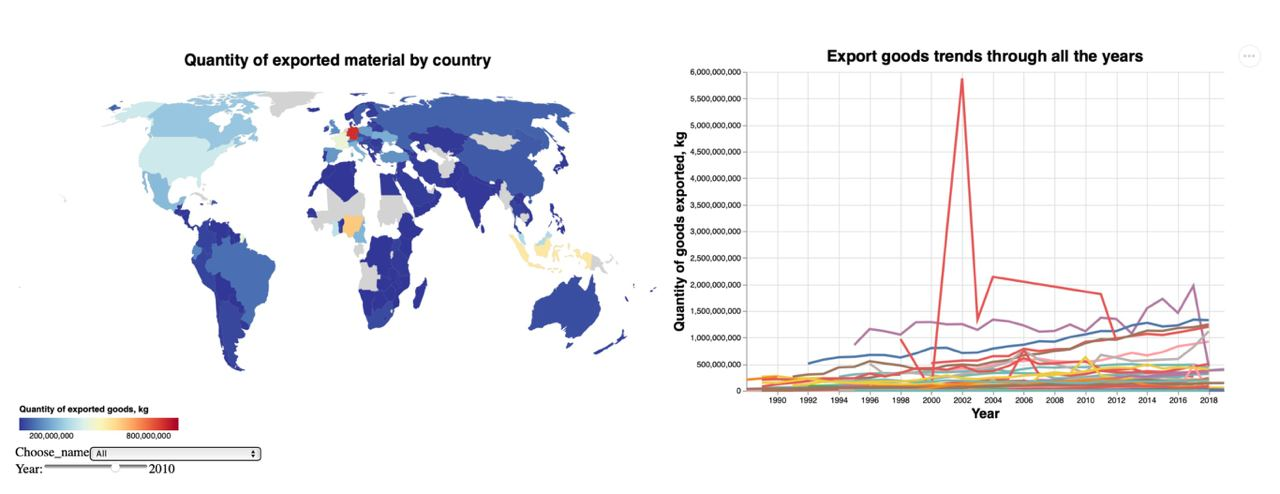

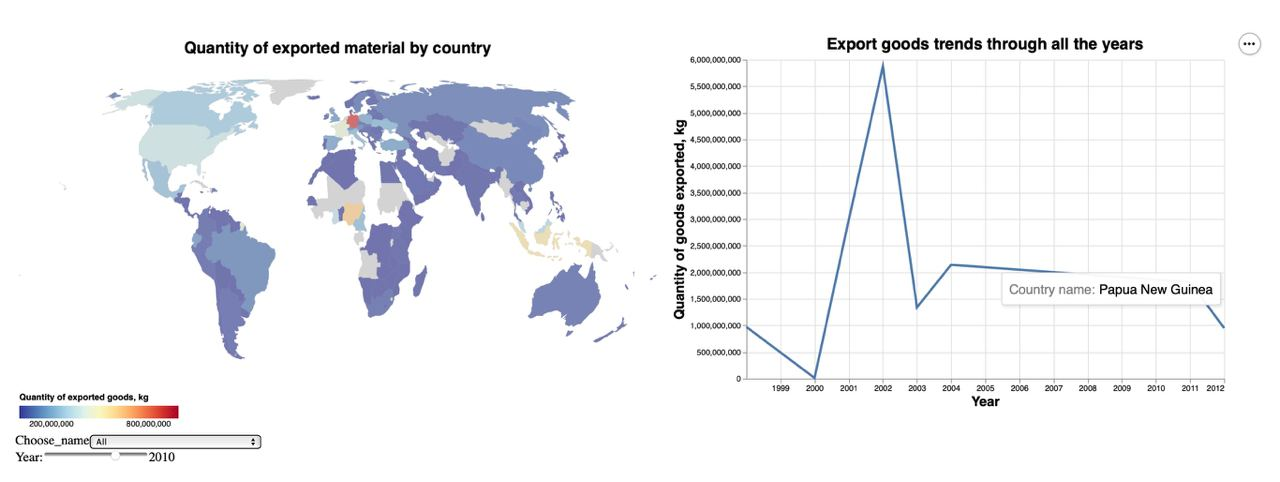

Багатолінійний графік справа є збереженим навіть під час взаємодії з картою для того, щоб могти порівняти тренди для двох країн: однієї, виділеної кліком на самому графіку, та іншої, виділеної кліком на карті. Таким чином можна зафіксувати одну країну на графіку і порівнювати динамічно з кількома в залежності від розташування на мапі. Можна піти і зворотним шляхом: зафіксувати країну на графіку з випадаючого вікна і порівнювати з країною вибору на карті. Ідея для покращення -- динамічно додавати легенду в залежності від вибору країн, проте реалізація додавання легенди в бібліотеці altair унеможливлює появу легенди після кліку, а якщо залишати легенду за дефолтними параметрами, то вона займатиме значиний обсяг візуалізації, і буде просто непотрібною (коли відображаються лінійні тренди для усіх країн). Я знаю, що в такому випадку користувачу доводитиметься наводити на лінію для показу назви конкретної країни, проте кращого рішення я не знайшла.

Гістограма була б і справді чудовим рішенням замість лінійного графіку, проте також не вирішує проблеми багатолінійності, а тренд зчитується складніше. 

Палетка кольорів була вибрана на мапі від червоного до синього, де червоний асоціюється з більшими обсягами експорту, а синій -- з меншими, для простішого зчитування. 

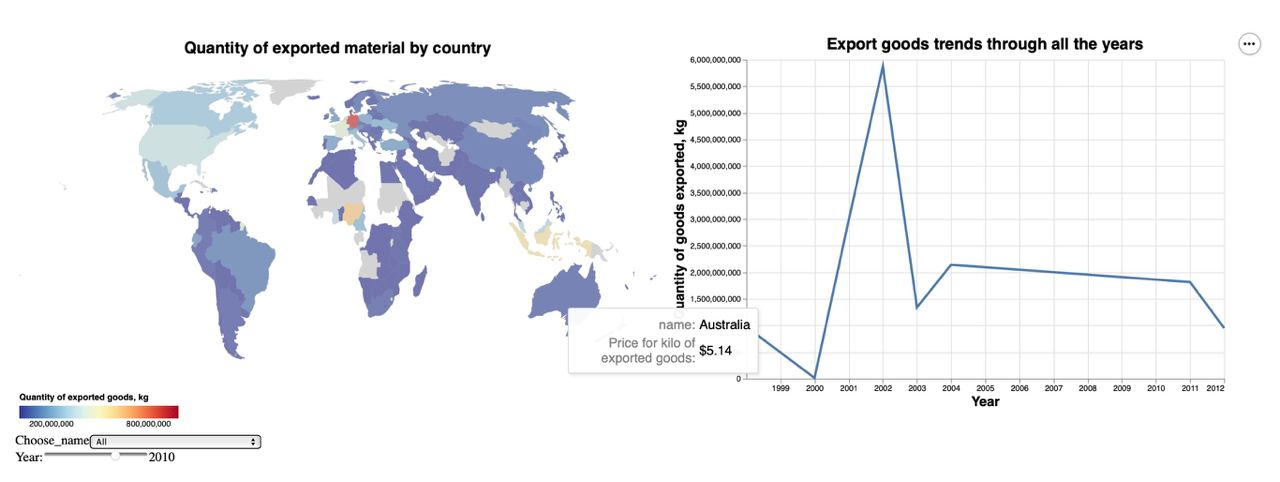

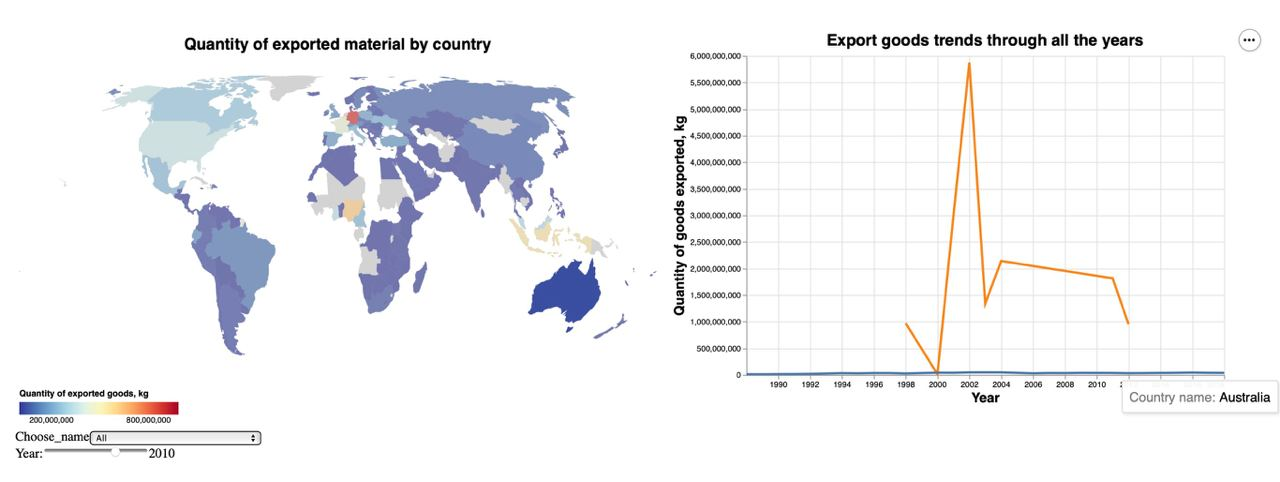

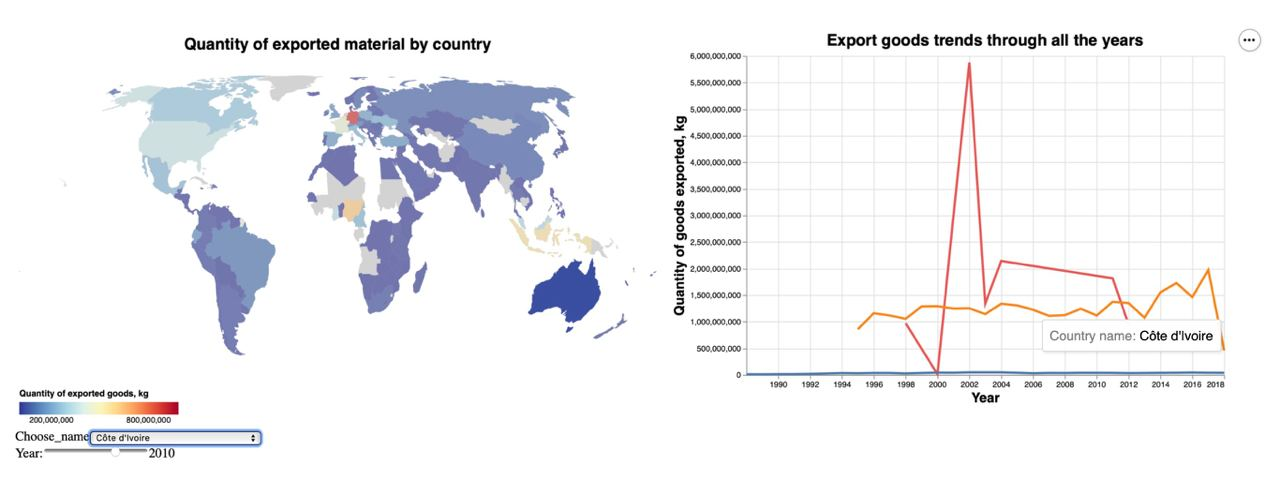

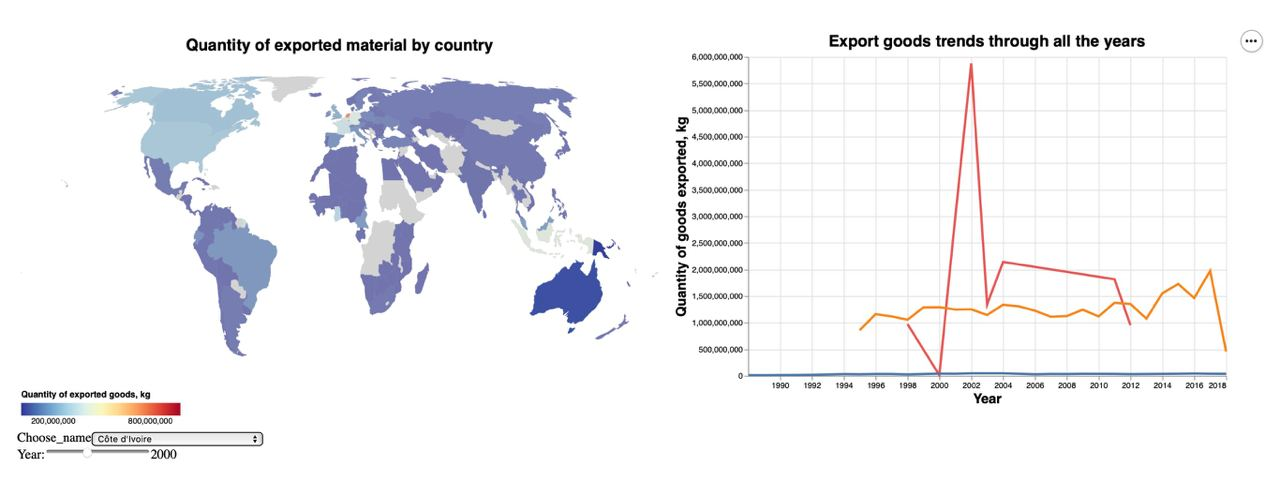

# Запитання 2: Як змінювались обсяги виробництва різних типів продукції впродовж років?

Для відповіді на це запитання я розглядала наступні варіанти:

1) гістограма для кожного з років з можливістю вибрати типи для порівняння -- проте таке рішення з початку виглядало заплутано, і порівнювати можна було б тільки 2 типи: один, вибравши з випадаючого вікна, і інший, вибраний з допомогою тултіпу : використання тултіпу (коли всі типи за раз на одному графіку) для вибору одного теж не було б ефективним, так як легко попасти не на той тип;

2) лінійний тренд для кожного з типів -- складність у порівнянні;

3) пай чарт з можливістю змінювати його в залежності від років -- складно відслідковувати тренд;

4) скаттер плот -- складно відстідковувати тренд. 

Тому я вирішила поєднати інтерактивно лінійний тренд зі динамічний пай чартом. 

In [94]:
data = pd.read_csv('UNdata_Export_20211219_151223778.csv')

data = data.groupby(['Commodity', 'Year' ]).mean().reset_index()

data['year'] = data['Year'].astype(str)
options=[None]
options.extend(sorted(data.Commodity.unique().tolist()))
labels=['All']
labels.extend(sorted(data.Commodity.unique().tolist()))
input_dropdown = alt.binding_select(options = options, labels=labels)
select_sector = alt.selection_single(fields = ['Commodity'], bind = input_dropdown, name='Choose')
select_sector_click = alt.selection_single(on = 'click', fields = ['Commodity'], nearest = False, empty = 'all')

trend = alt.Chart(data, title='Trend of cocoa goods production').mark_line().encode(
    x = alt.X(field='year', 
              type='temporal'
             ),
    y = alt.Y('Quantity:Q', title='Quantity of produced, kg'),
    
    tooltip = [
        alt.Tooltip('Commodity:O', title='Sector')
    ],
    detail = alt.Detail('Commodity:O'),
    size = alt.condition(
    (select_sector) | (select_sector_click),
    alt.value(3),
    alt.value(0.2)),
    color = alt.Color('Commodity:O'),
).add_selection(select_sector
).add_selection(select_sector_click
).transform_filter( (select_sector_click) | (select_sector)
).properties(width = 800, height = 400)

slider = alt.binding_range(name='Year:', min=min(data['Year']), max=max(data['Year']), step=1)
select_year =alt.selection_single(name="SelectorName", fields=['Year'],
                            bind=slider,init={"Year": 2010})


pie_chart = alt.Chart(data,  title='Cocoa goods production by sector for a given year').mark_arc().encode(
    theta=alt.Theta(field="Quantity", type="quantitative"),
    color=alt.Color(field="Commodity", type="nominal",scale=alt.Scale(scheme='set3')),
    tooltip = [
        alt.Tooltip('Commodity:O', title='Sector')
    ]
).add_selection(select_year
).add_selection(select_sector_click
).transform_filter( select_year
).properties(width = 400, height = 400)

alt.hconcat(pie_chart, 
            trend
           ).configure_view(
    strokeWidth=0
).configure_title(fontSize=23).configure_legend(
labelLimit = 0,
labelFontSize=12,
titleFontSize=17
) .configure_axis(
    labelFontSize=10,
    titleFontSize=17
)

Displaying chart at http://localhost:21235/

Палетка кольорів була обрана таким чином, щоб кольори не повторювались. 

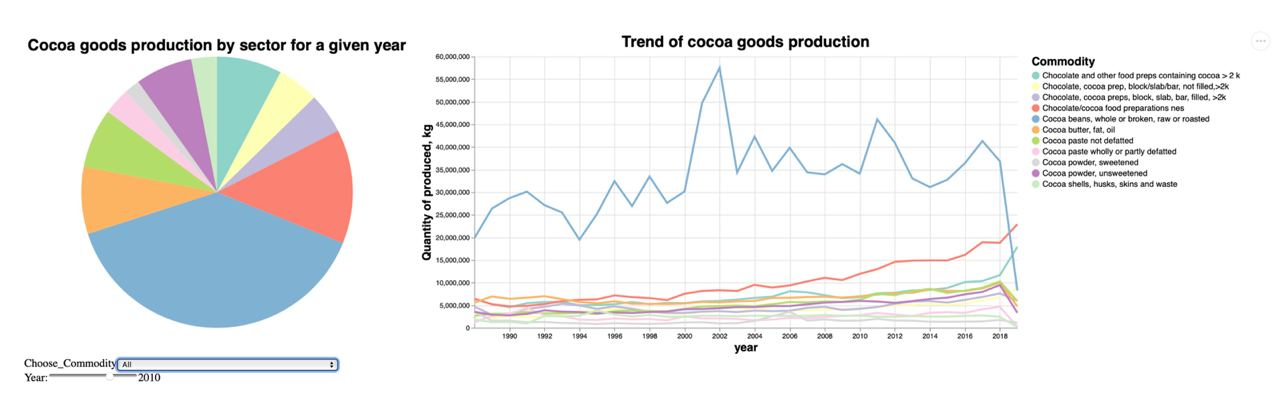

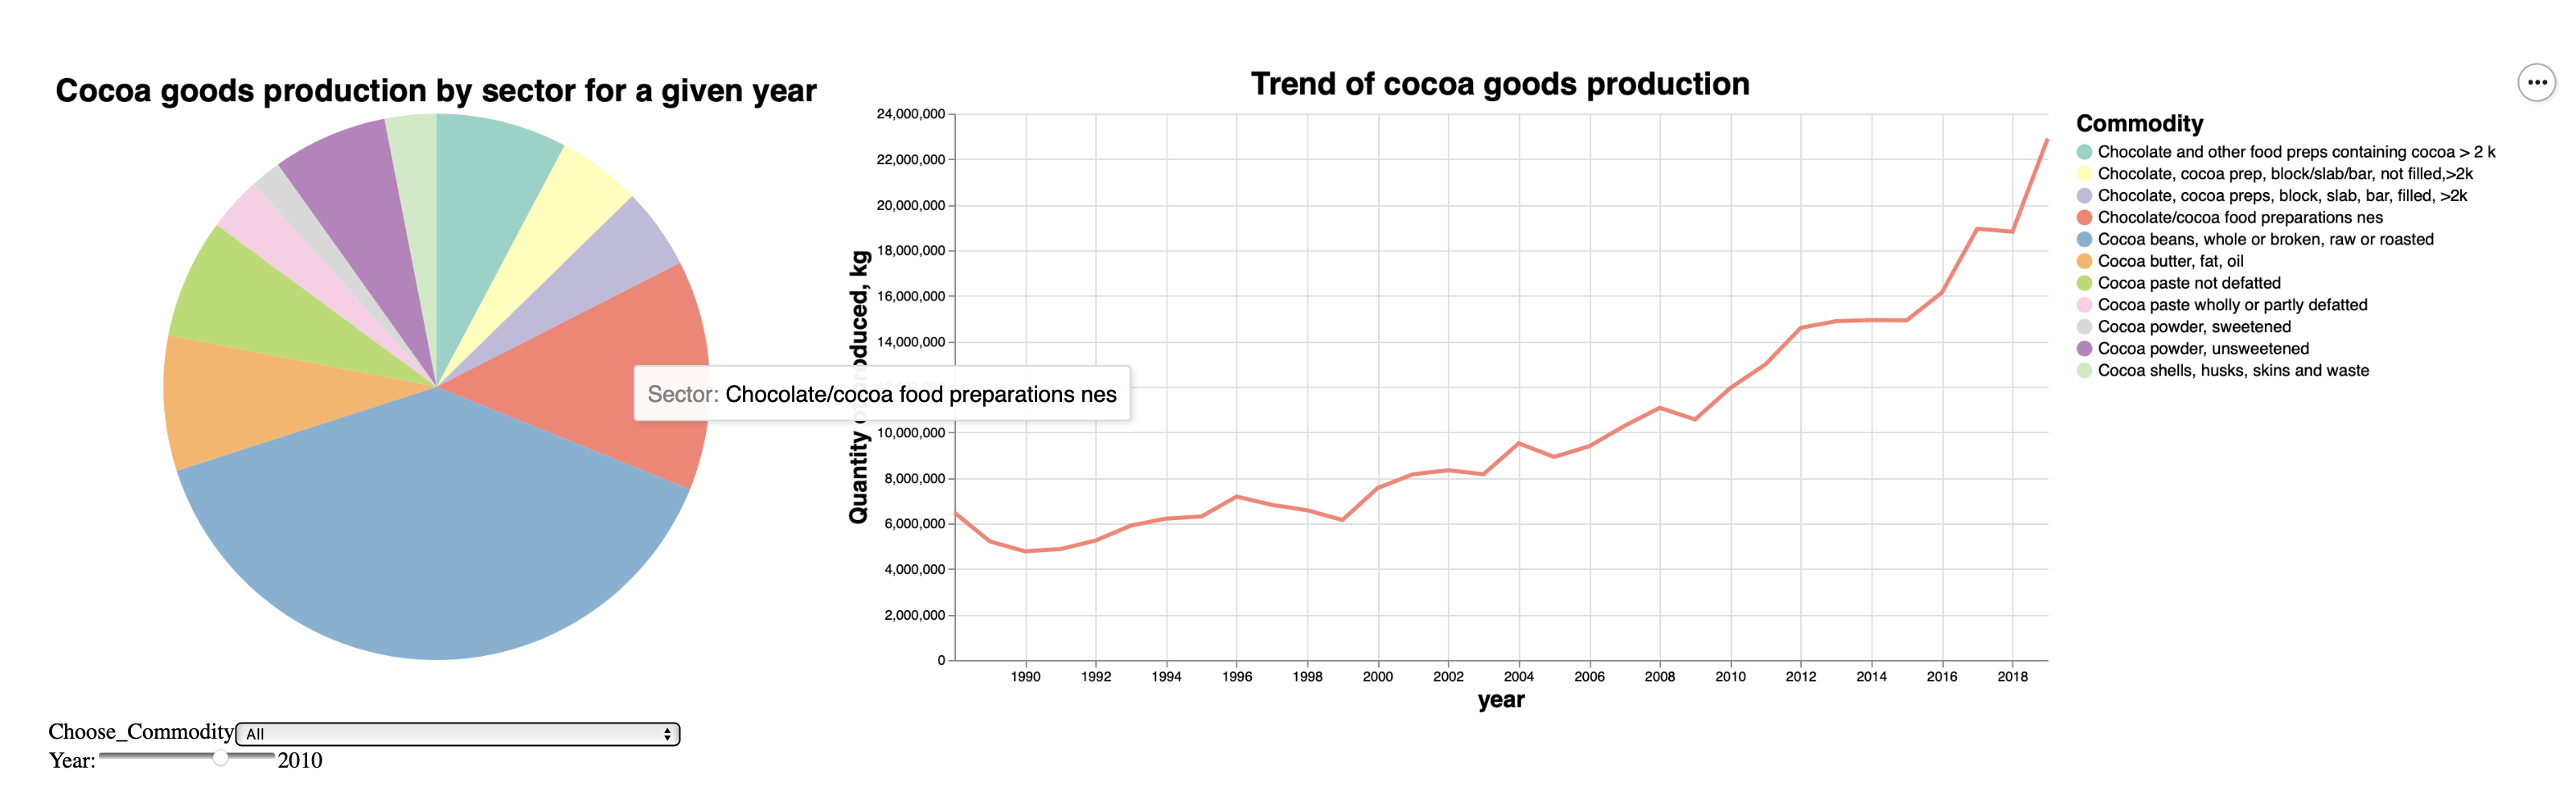

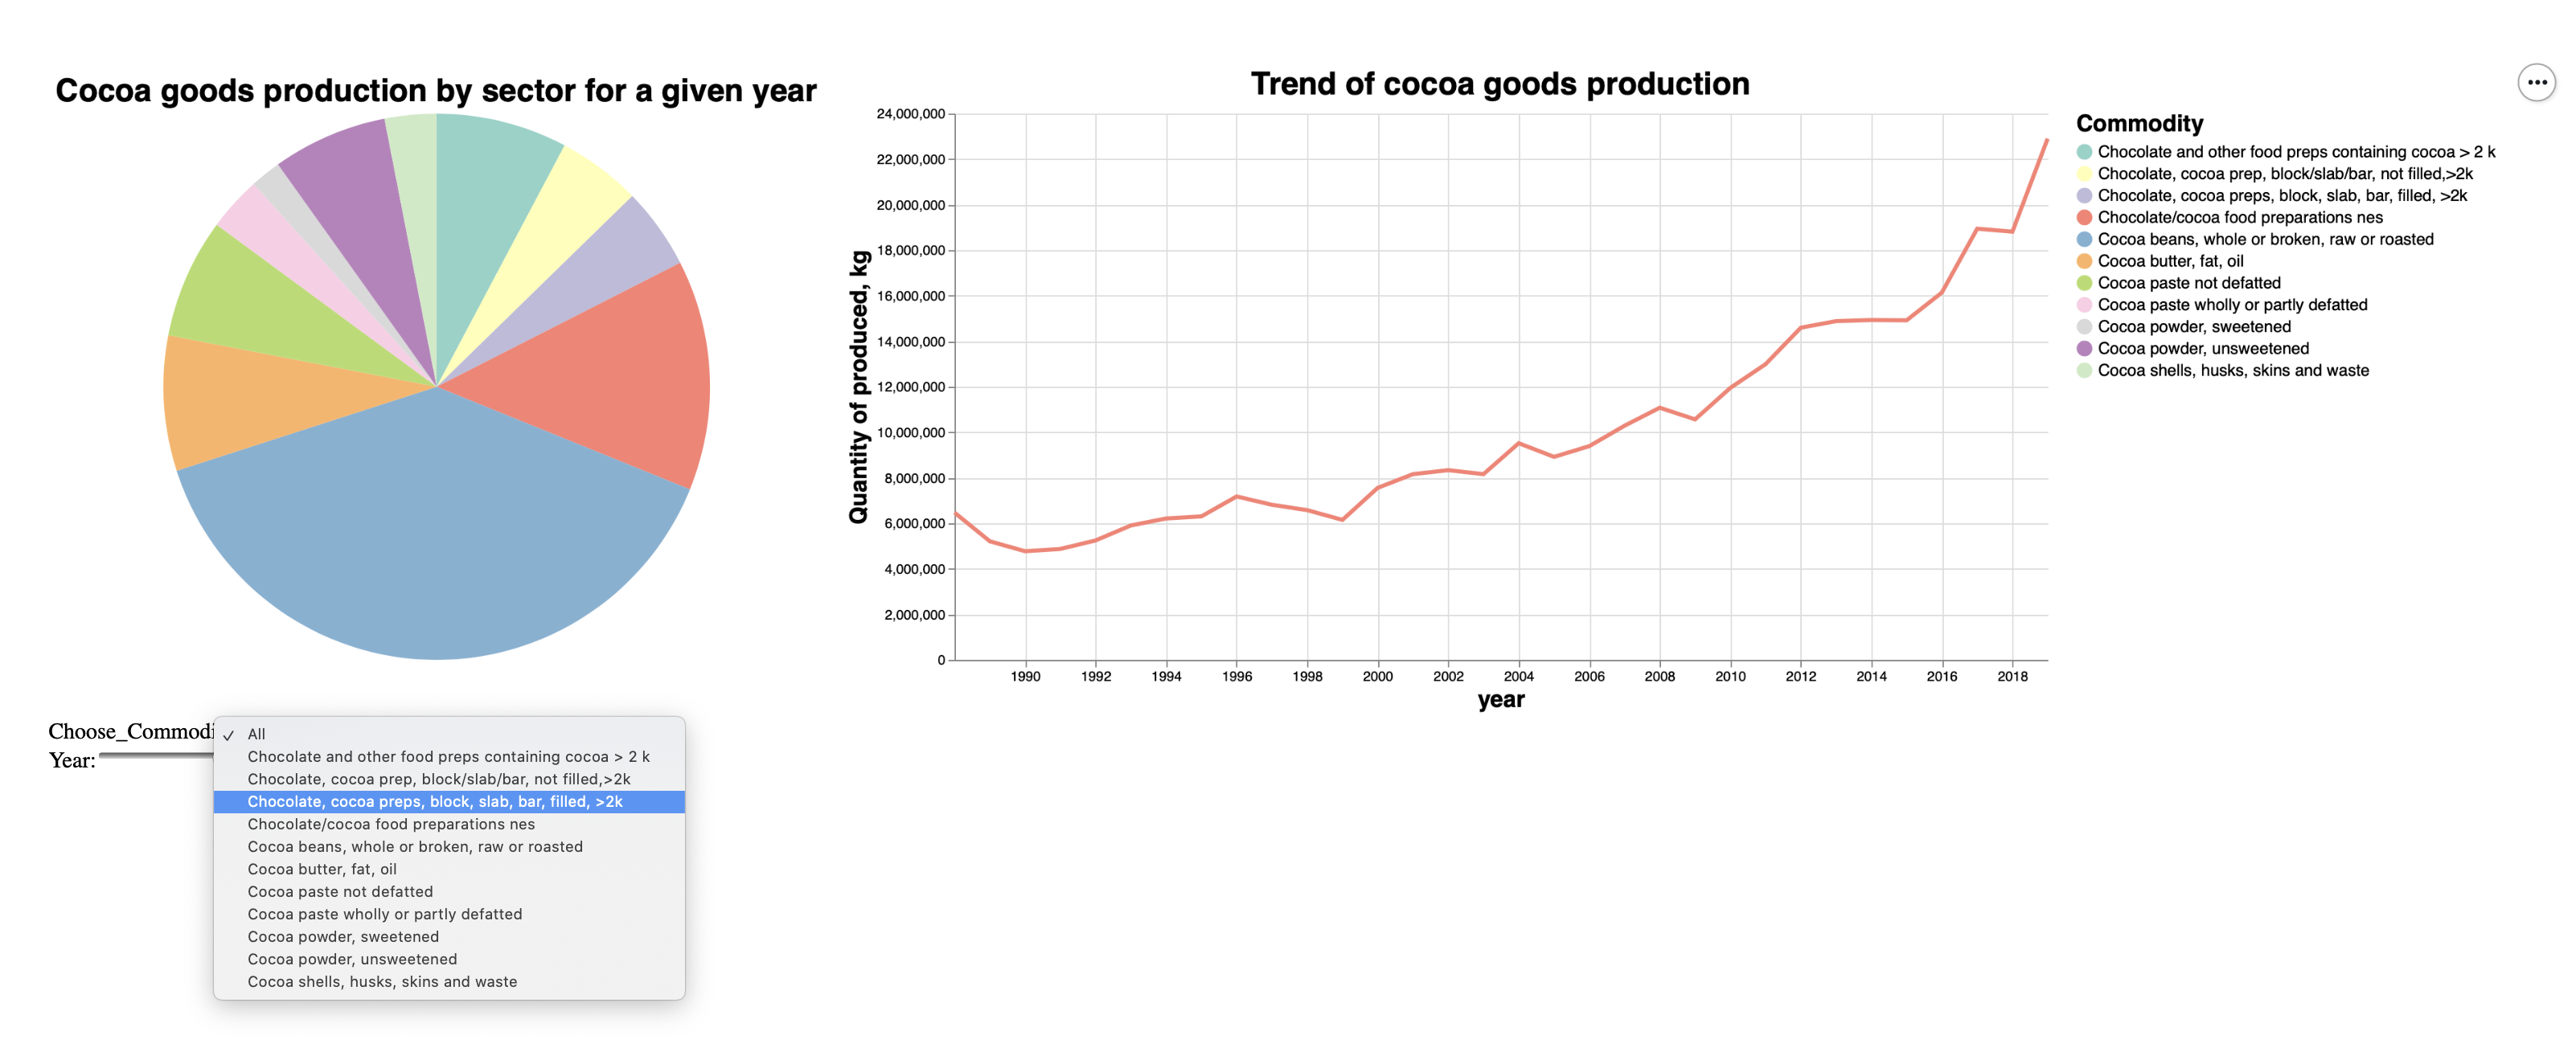

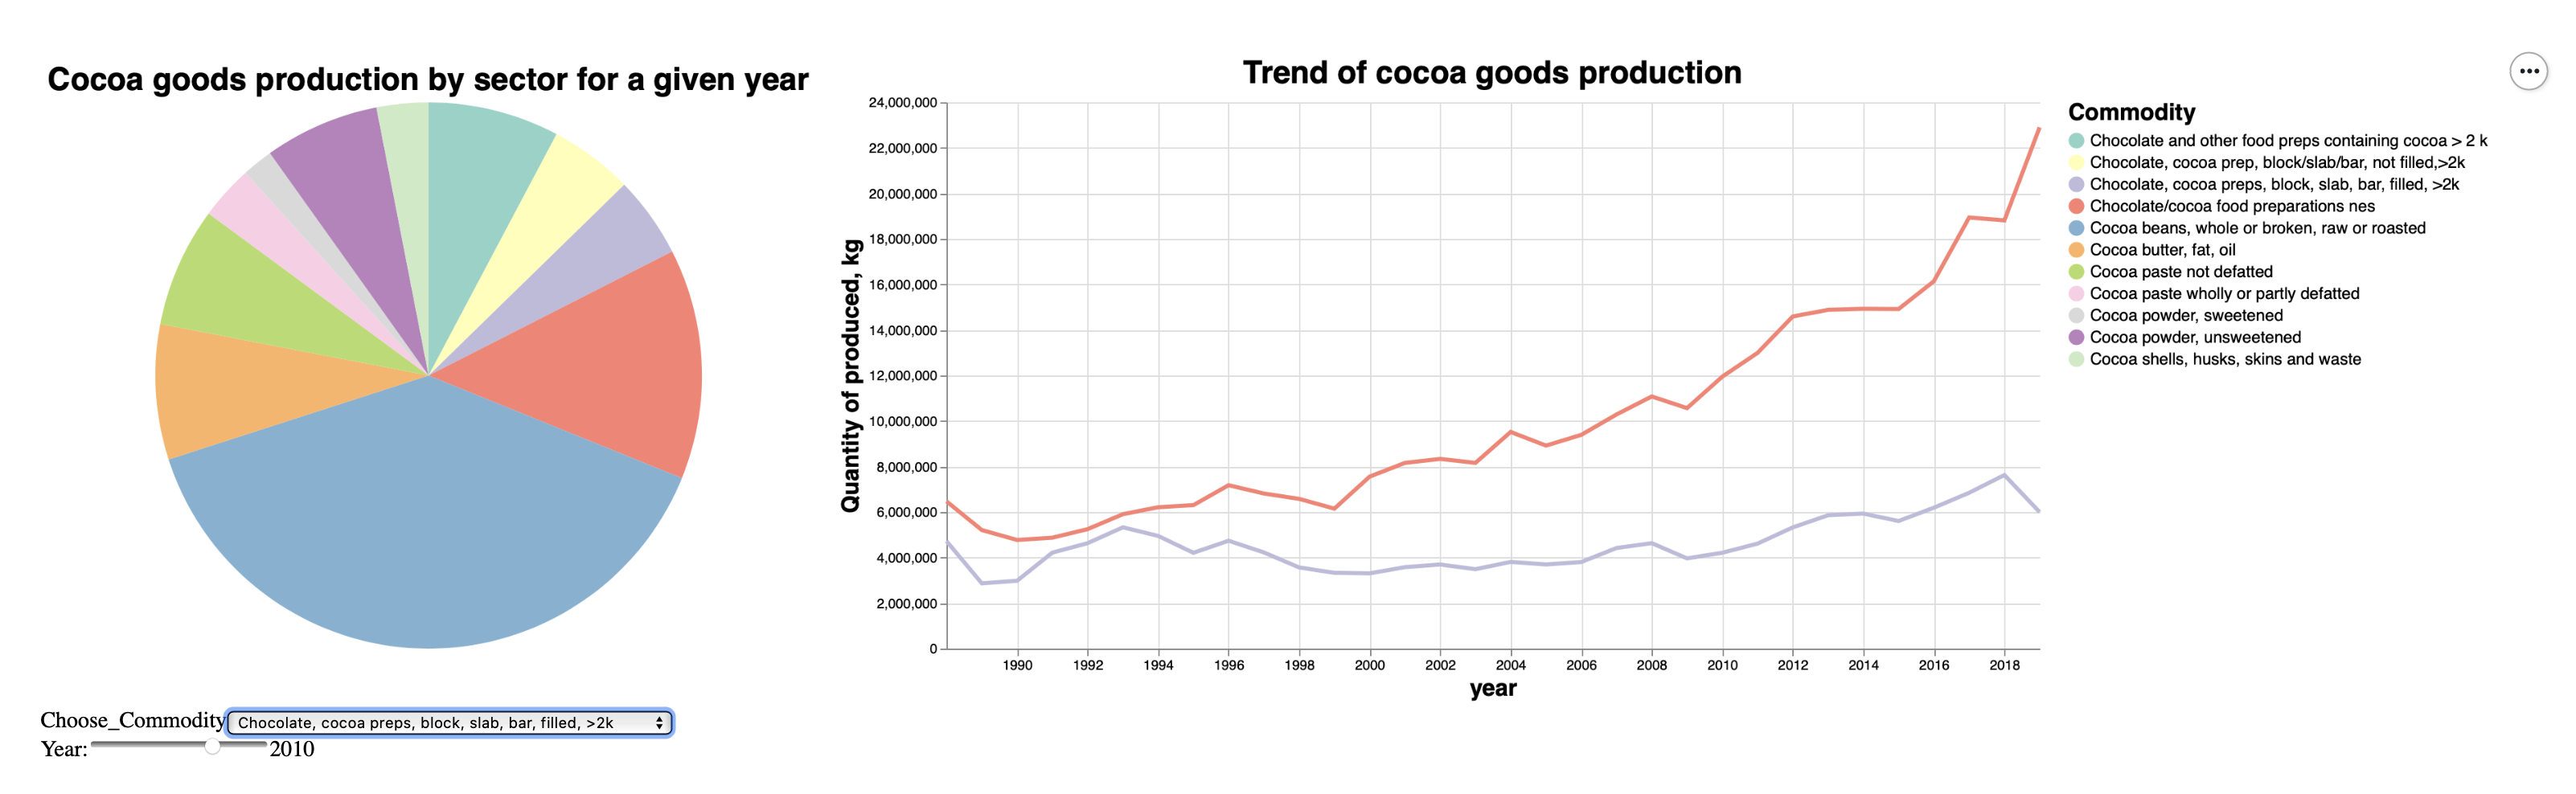

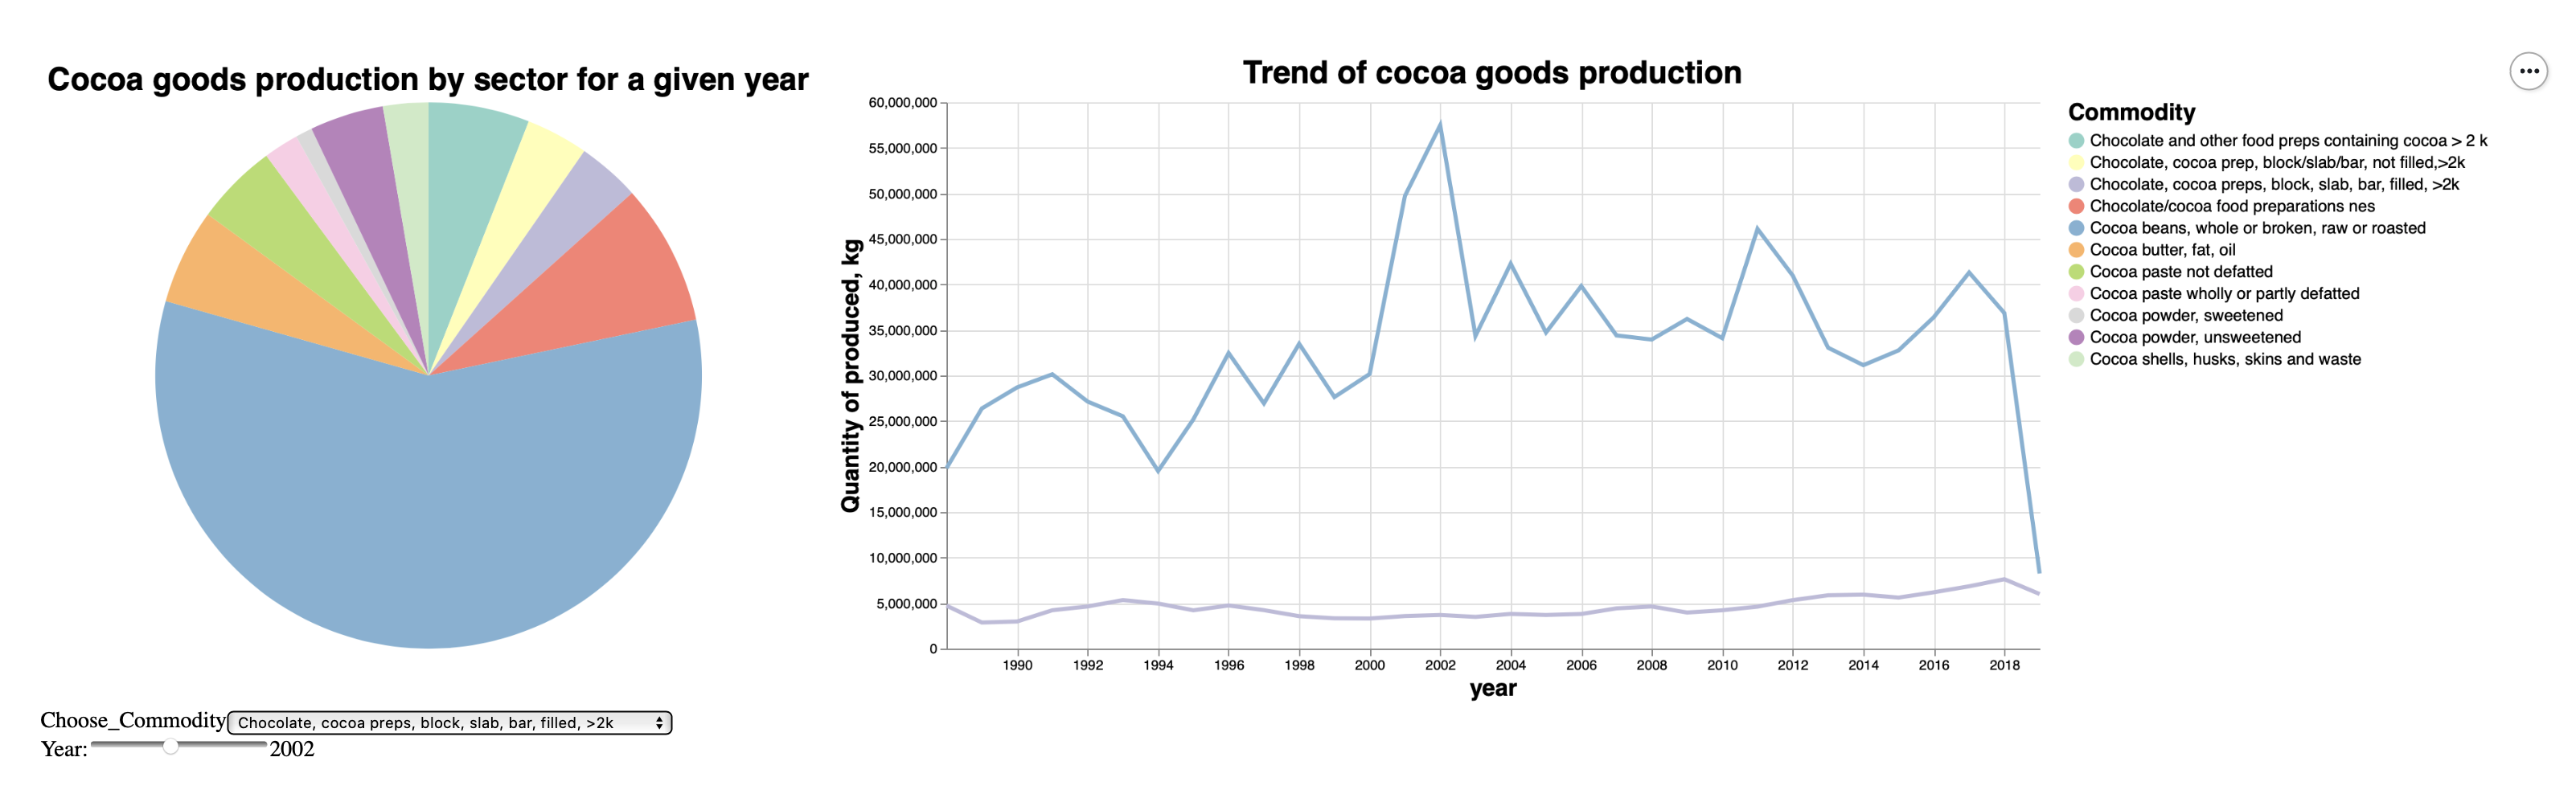

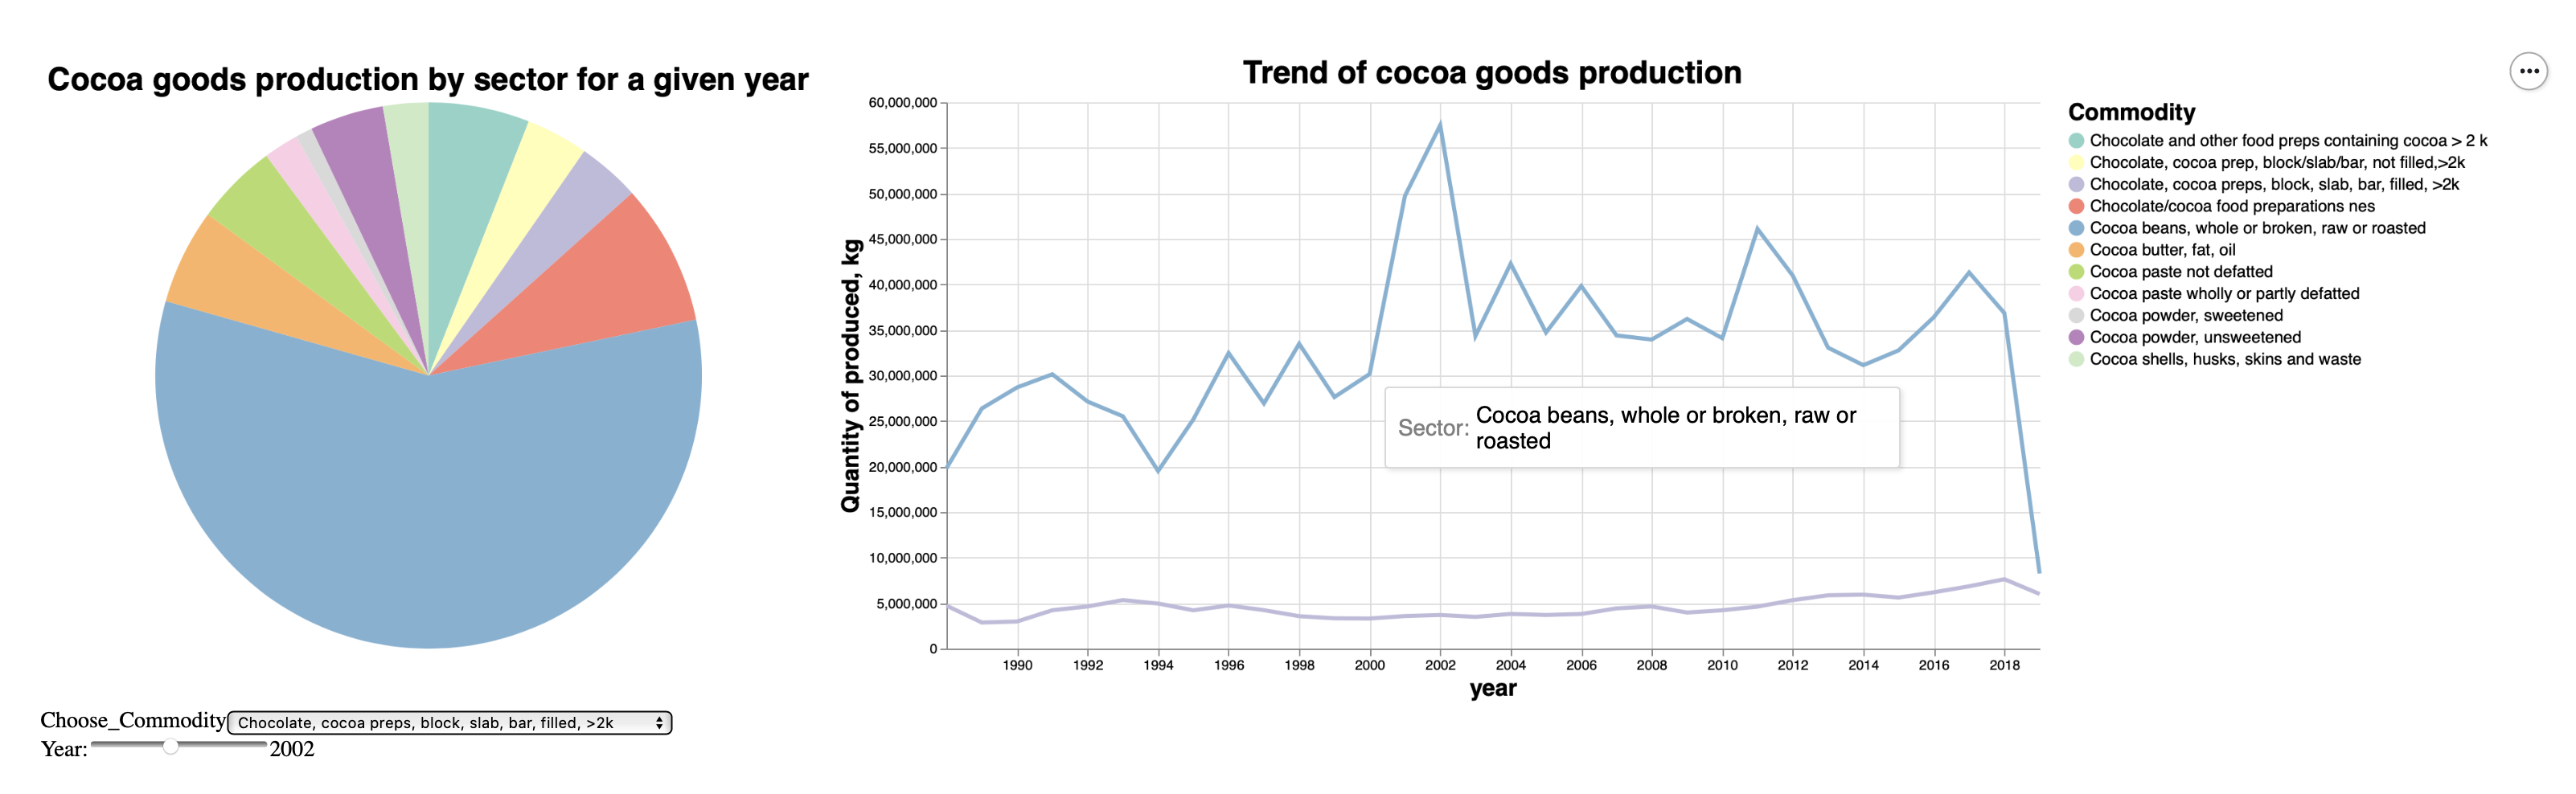

# Запитання 3: Як змінюється ціна за вироблення товару в залежності від певного типу продукції?

Варіанти візуалізації, які я розглядала:

1) лінійний тренд, з можливістю вибирати з випадаючого вікна і кліком сектори для порівняння -- інтуїтивно лінійє відображає залежність, тут же ніякої залежності ціни від типу немає;

2) пайчарт -- складно зчитувати, так як інтуїтивно кожен сектор відображає частинку цілого -- 100%, а у випадку цін такої інтуіції поза їх сумарним значенням немає;

3) box plot -- занадто велика кількість секторів для того, щоб порівнювати одночасно 11 box plots між собою.

Обрала гістограму з можливістю виділяти потрібний сектор і порівнювати його з загальним трендом, використовуючи сіру гістограму на фоні. 

In [98]:
data['$/kg'] = data['Trade (USD)']/data['Quantity']
input_dropdown = alt.binding_select(options = options, labels=labels)
select_sector = alt.selection_single(fields = ['Commodity'], bind = input_dropdown, name='Choose')

histogram_context  = alt.Chart(data).mark_bar(color = 'lightgray').encode(
    x = alt.X("$/kg:Q", bin=alt.Bin(extent=[0, 7], step=0.25), title='Price, $'),
    y = alt.Y('count()', title='')
)

hist = alt.Chart(data, title='Distribution of price for kilogram of cocoa goods over sectors').mark_bar().encode(
    x = alt.X("$/kg:Q",bin=alt.Bin(extent=[0, 7], step=0.25), title='Price, $'),
    y = alt.Y('count()', title=''),
    color = alt.value('FC9C3C')
).add_selection(select_sector
).transform_filter( select_sector
)

histogram = (histogram_context+hist).properties(width = 800, height = 400
).configure_title(fontSize=23).configure_axis(
    labelFontSize=10,
    titleFontSize=17
)
histogram

Displaying chart at http://localhost:21235/

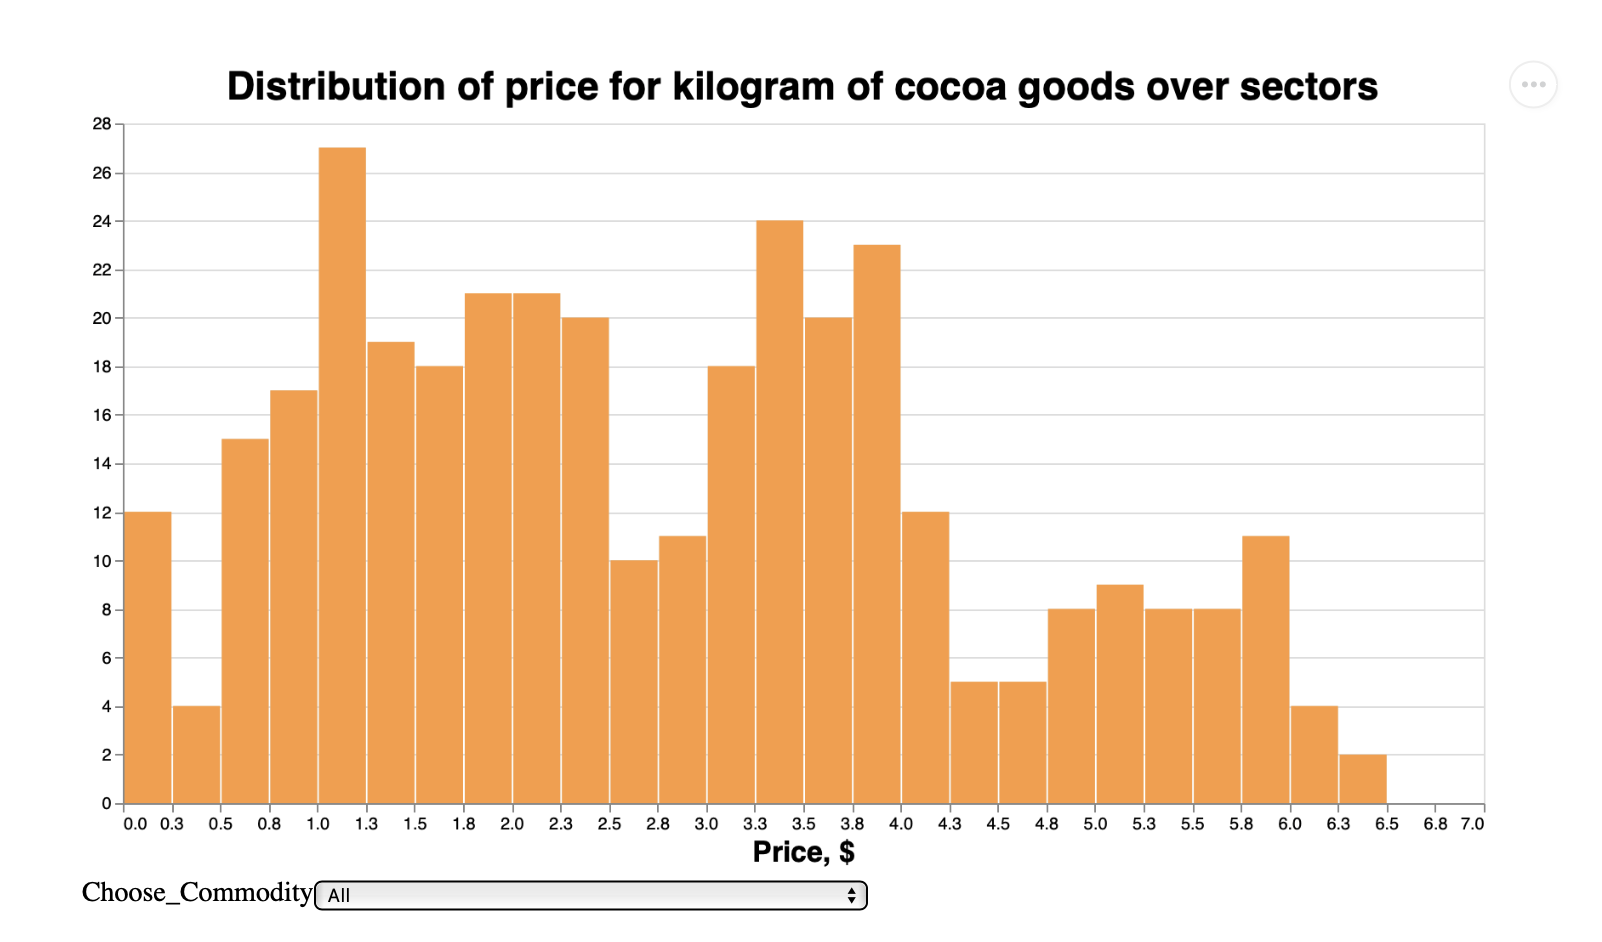

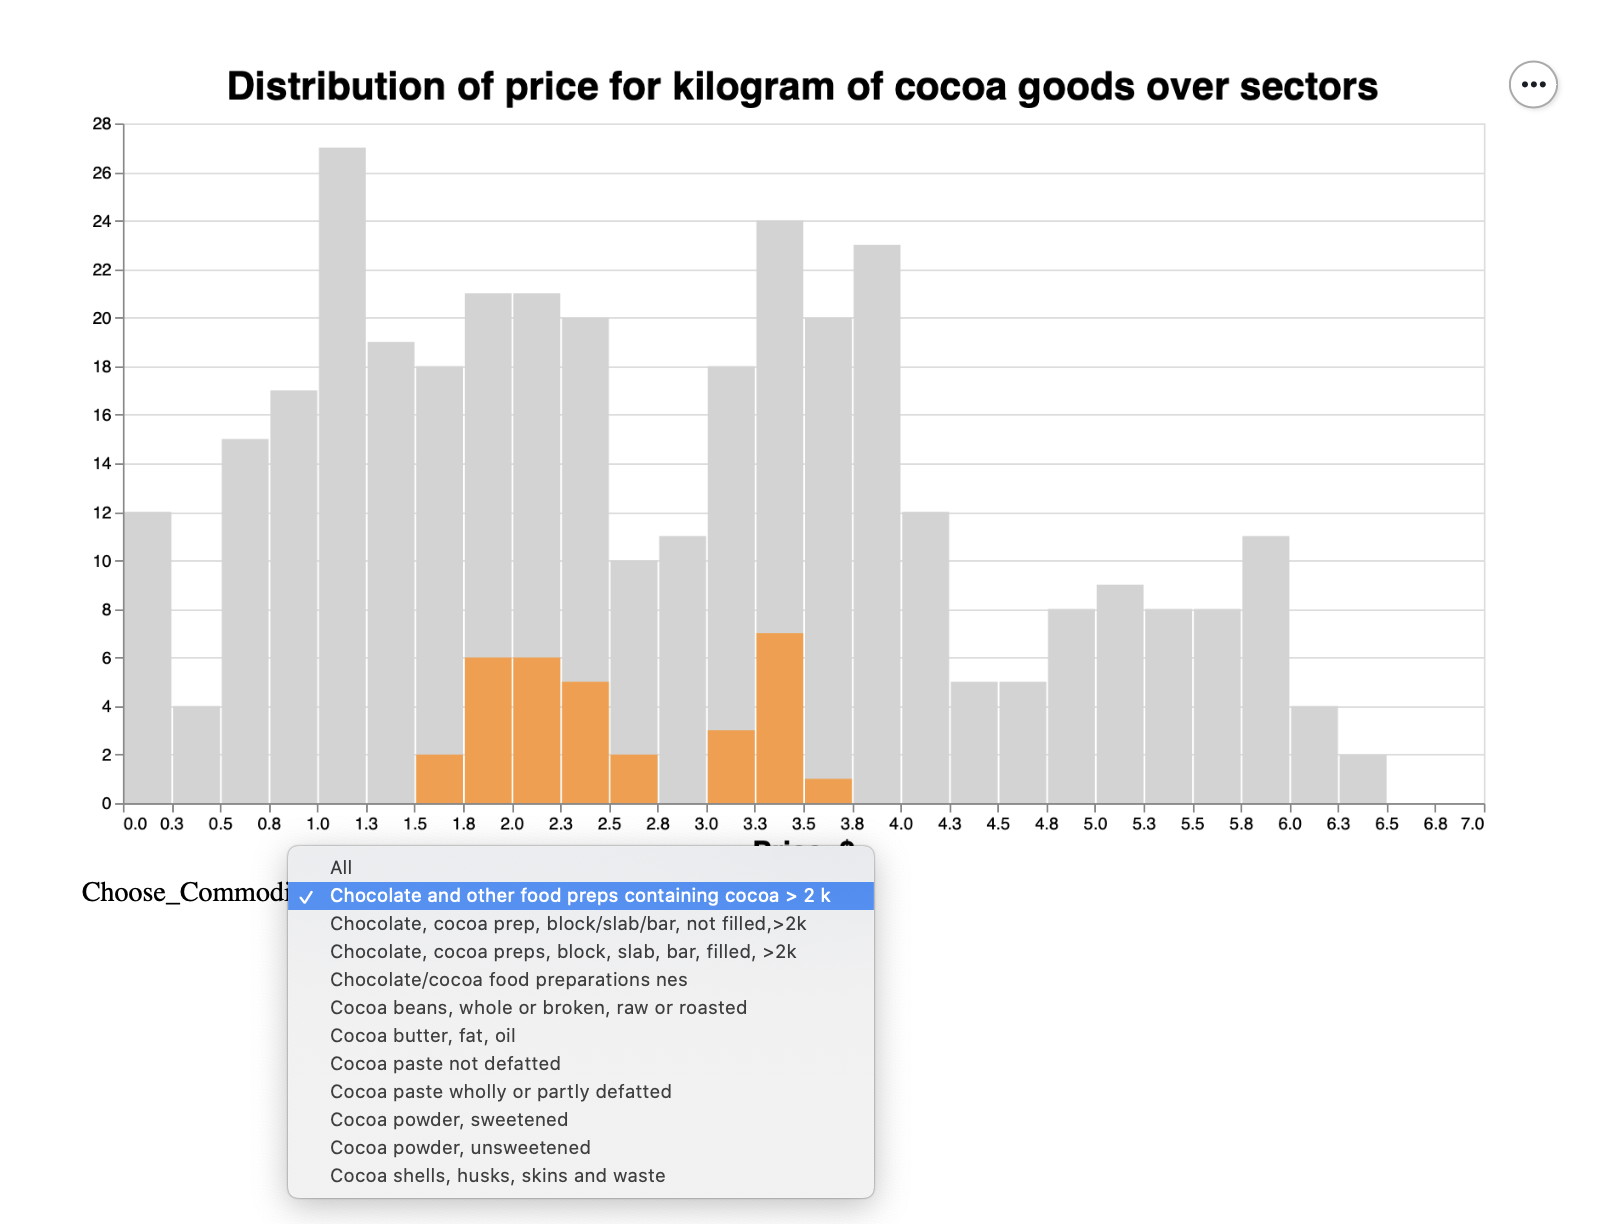

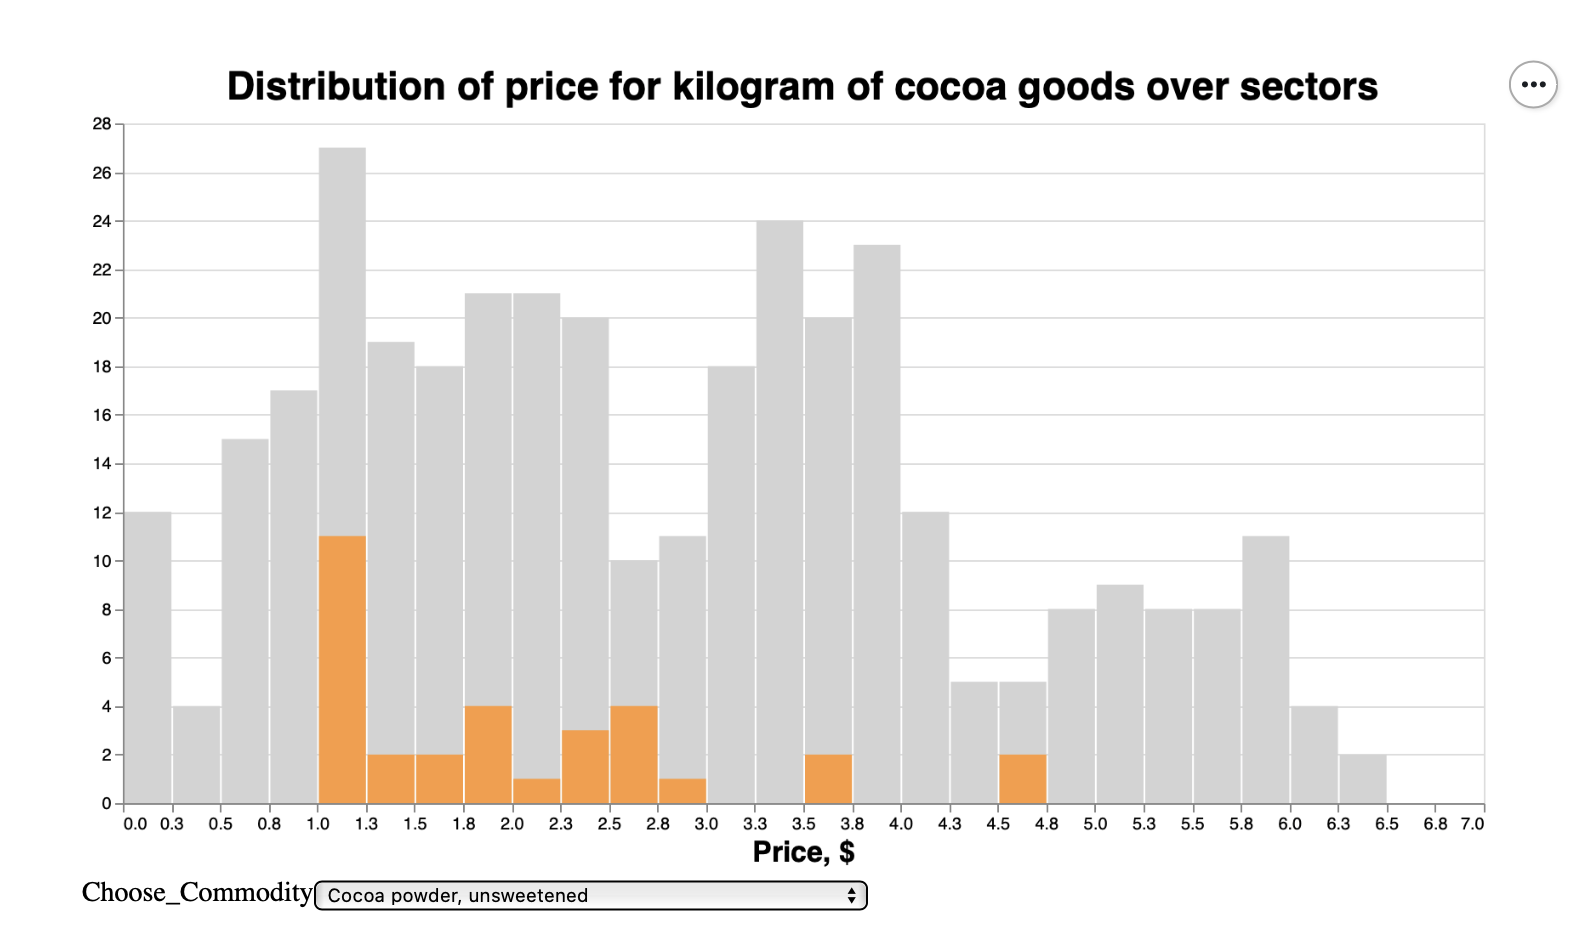

# Запитання 4: Як змінюється ціна за експортований кілограм в залежності від регіону?

Для того, щоб погрупувати країни по регіонах, я використаю дані від фундації gapminder, з якими ми до того працювали на курсі.


Для цієї візуалізації я розглядала наступну альтернативу -- декілька гістограм порівнюючи між собою середні значення цін -- теж давало б інтуіцію читачеві, але не показувало б розподілу -- наскільки розкиданою є ціна для кожного регіону. Також думала над тим, щоб візуалізувати використовуючи гістограму, але таким способом складніше порівнювати між собою різні сектори.

Вирішила обрати варіант бокс плот для кожного з регіонів. Вибір кольорової палітри -- просто щоб в межах регіонів кольори не повторювались, алтаір автоматично підтягує різні кольори. 

In [176]:
df = pd.read_csv('gapminder_country_data.csv')
df.drop(['time'], axis = 1, inplace = True)
df.columns = ['id', 'gdp_per_cap', 'life_expectancy', 'population', 'country', 'region']
df.drop(['gdp_per_cap'], axis = 1, inplace = True)
df.drop(['life_expectancy'], axis = 1, inplace = True)
df.drop(['population'], axis = 1, inplace = True)
df.id = df.id.str.upper()

data = pd.read_csv('UNdata_Export_20211219_151223778.csv')
data['country'] = data['Country or Area']
to_drop = [i for i, r in data[data['Weight (kg)']==0.0].iterrows()]
data.drop(to_drop, axis = 0, inplace = True)

data['$/kg'] = data['Trade (USD)']/data['Weight (kg)']
data= data[data['Flow']=='Export']
country_price = data.iloc[:,-2:]
country_price = country_price.groupby(['country' ]).sum().reset_index()

merged = country_price.merge(df)
merged.head()

country         $/kg   id    region
0              Albania   124.697525  ALB    Europe
1              Algeria  1389.680428  DZA    Africa
2              Andorra   298.298732  AND    Europe
3               Angola    75.029208  AGO    Africa
4  Antigua and Barbuda   462.859807  ATG  Americas

In [177]:
# data['year'] = data['Year'].astype(str)
# options=[None]
# options.extend(sorted(merged.region.unique().tolist()))
# labels=['All']
# labels.extend(sorted(merged.region.unique().tolist()))

# input_dropdown = alt.binding_select(options = options, labels=labels)
# select_region = alt.selection_single(fields = ['region'], bind = input_dropdown, name='Choose')
# regions = labels

# #color changing marks
# histogram_context  = alt.Chart(merged).mark_bar(color = 'lightgray').encode(
#     alt.X("$/kg:Q", bin=alt.Bin(extent=[0, 5000], step=200), title='Price, $'),
#     y=alt.Y('count()', title='Frequency'),
# )

# hist = alt.Chart(merged).mark_bar().encode(
#     alt.X("$/kg:Q", bin=alt.Bin(extent=[0, 5000], step=200)),
#     y=alt.Y('count()', title='Frequency'),
# )



# rating_radio = alt.binding_radio(options = options, labels=labels)

# rating_select = alt.selection_single(fields=['region'], bind=rating_radio, name="Select")
# rating_color_condition = alt.condition(rating_select,
# #                         alt.Color('region:N'),
#                       alt.value('#3a9aba'),
#                       alt.value('lightgray'))

# hist = hist.add_selection(
#     rating_select
# ).transform_filter(
#     rating_select
# ).encode(
#     color=alt.value('#3a9aba')
# ).properties(title="Price per kilogram of produced goods by region")

# (histogram_context + hist).properties(width = 800, height = 400).configure_title(fontSize=25) .configure_axis(
#     labelFontSize=10,
#     titleFontSize=17
# )

# Початковий варіант
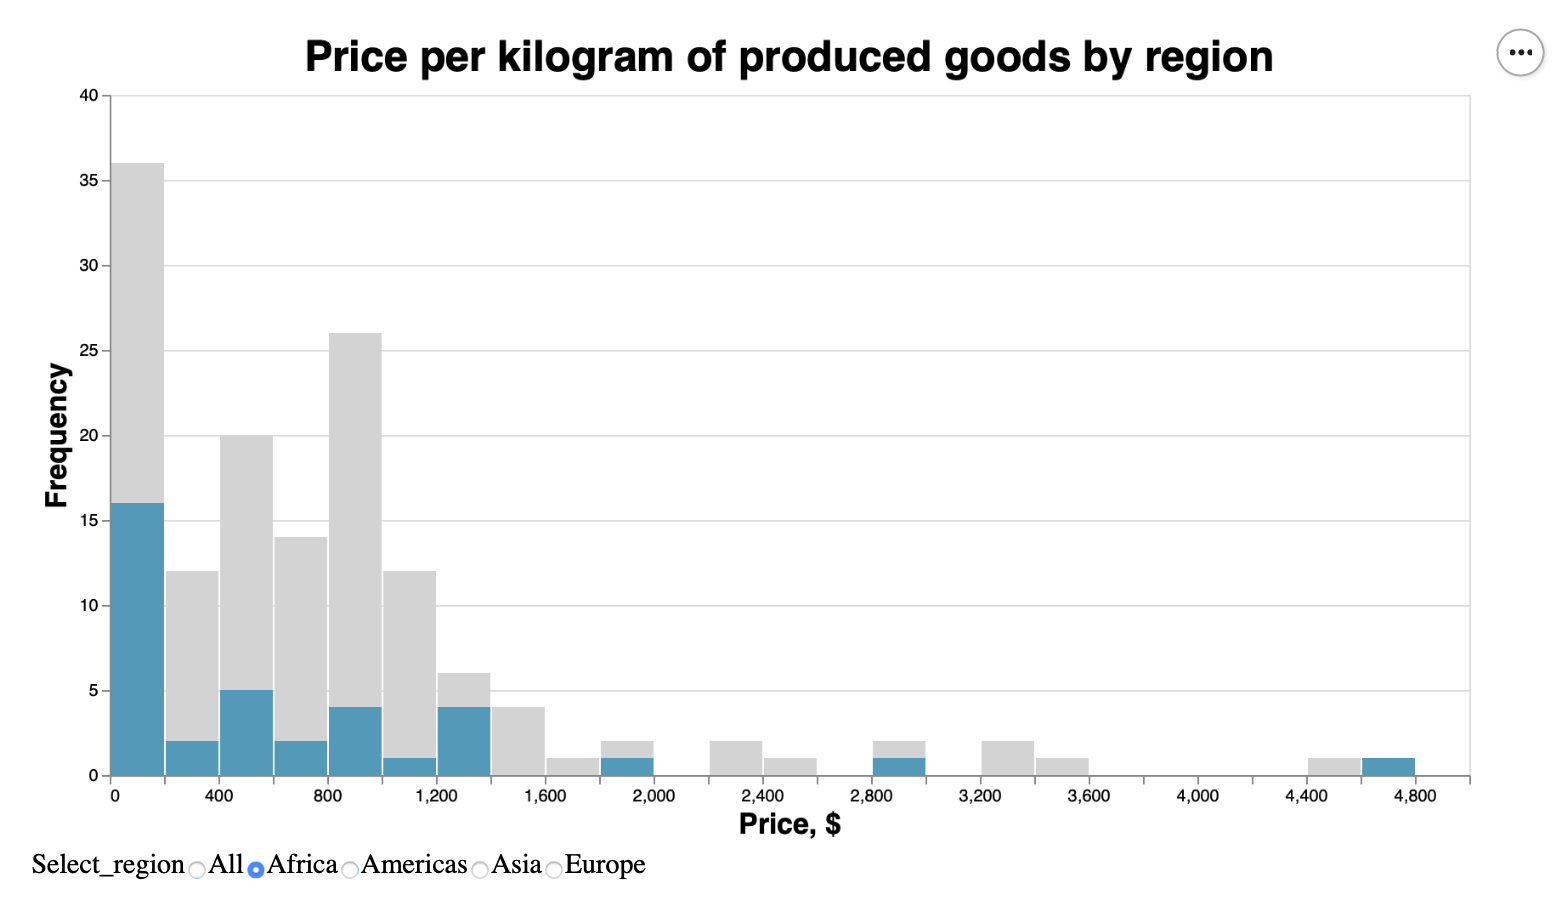

# Тултіпи!
Я пробувала редагувати значення на тултіпах (заокруглити) , але, вочевидь, altair для тултіпів на самих бокс плотах не може бути редагованим так, як звичайний тултіп, до прикладу, на мапах. 

In [178]:
merged = merged[merged['$/kg'] < 5000]
# ця фільтрація була зроблена для більш зрозумілого порівняння, 
# так як присутній лиш один запис у Африці, що перевищує цей показник, то я вирішила його прибрати.

In [179]:
select_region = alt.selection_single(on = 'click', fields = ['Flow'], nearest = False, empty = 'all')


alt.Chart(merged, title='Price distribution by regions').mark_boxplot(size=30, extent=0.5).encode(
    x=alt.X('$/kg:Q',scale=alt.Scale(zero=False), title='Price, $'),
    y=alt.Y('region:O', scale=alt.Scale(zero=False), title='Region'),
    color=alt.Color('region'),
    tooltip = [
        alt.Tooltip('$/kg:Q', format="$,.2f",
                   labelExpr='datum.value+"$"'),
#         alt.Tooltip("min($/kg):Q", title='Price for kilo of exported goods', format="$,.2f",
#                    labelExpr='datum.value+"$"'),
#         alt.Tooltip("mean($/kg):Q", title='Price for kilo of exported goods', format="$,.2f",
#                    labelExpr='datum.value+"$"'),
#         alt.Tooltip("max($/kg):Q", title='Price for kilo of exported goods', format="$,.2f",
#                    labelExpr='datum.value+"$"'),
#         alt.Tooltip("stdev($/kg):Q", title='Price for kilo of exported goods', format="$,.2f",
#                    labelExpr='datum.value+"$"')
    ]
).properties(width = 800, height = 400).configure_title(fontSize=25) .configure_axis(
    labelFontSize=16,
    titleFontSize=17
).configure_legend(
labelLimit = 0,
labelFontSize=12,
titleFontSize=17
)

Displaying chart at http://localhost:21235/

# Фінальний варіант


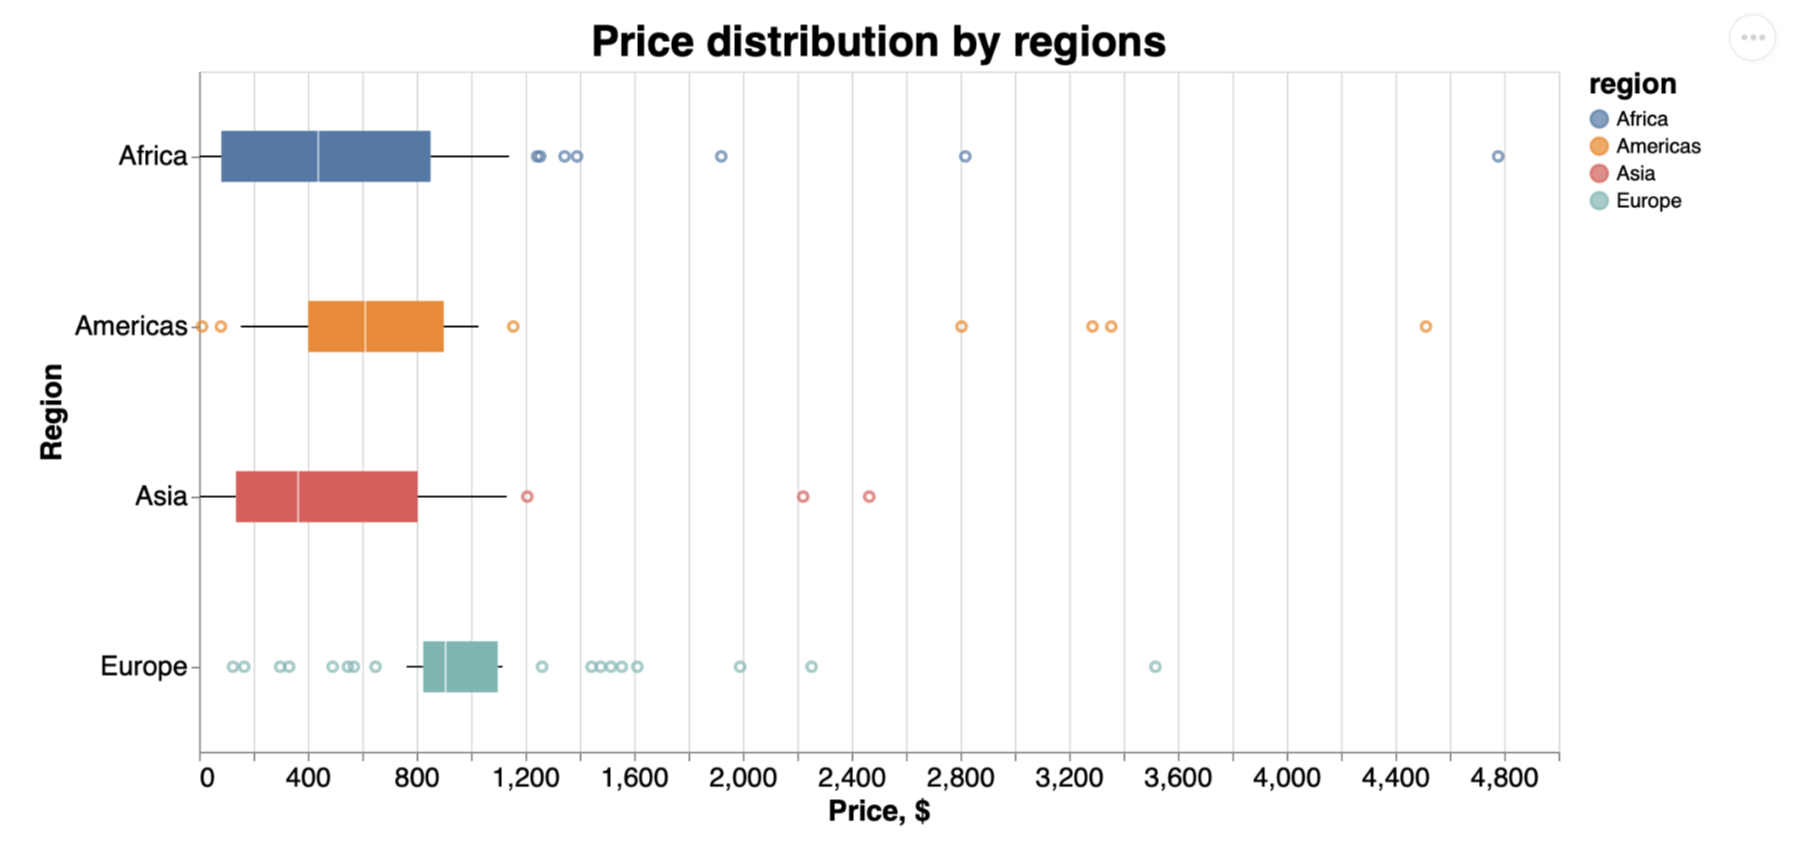

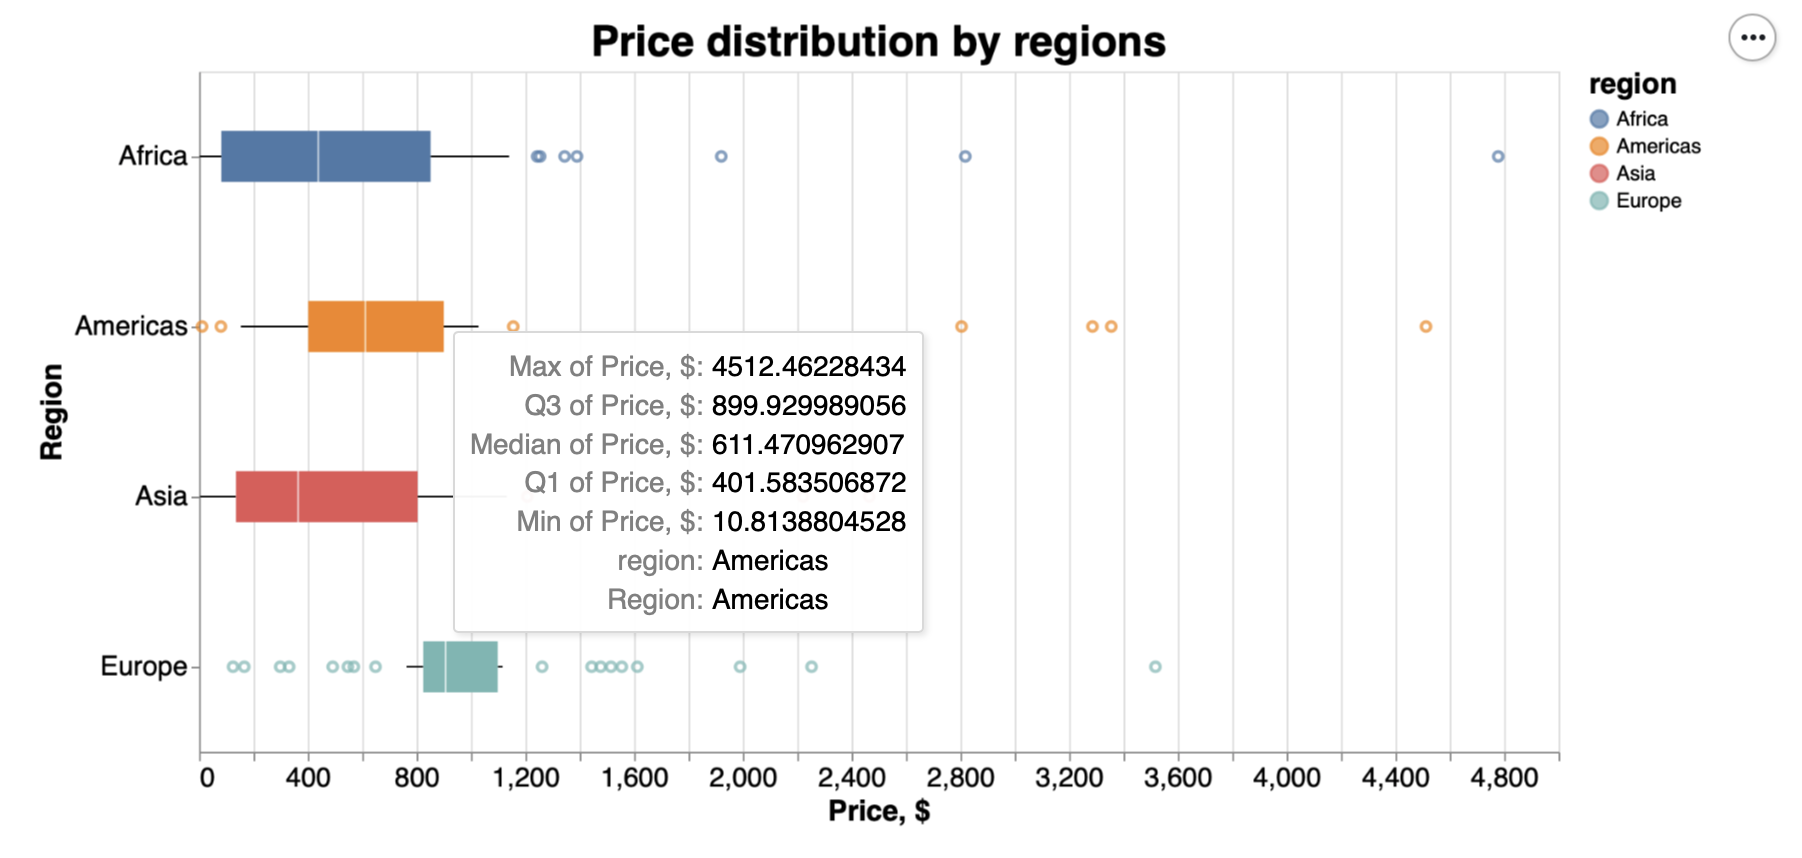

# Запитання 5: Обсяги якого товару переважають в межах кожного регіону: імпортованого чи експортованого? 

Для цього завдання гістограма з 2 стовпчиками для кожної категорії є, як на мене, найкращим варіантом, так як дозволяє не тільки порівняти обсяги імпорту і експорту в межах кожної країни, але і порівнювати країни між собою. Додавання інтеракції з можливістю після кліку порівняти тільки одну категорію робить ще простішим порівнювання в межах країн. 

Альтернативи:

1) пай чарт для кожної з країн -- складніше порівнювати між країнами

2) лінійний графік з двома лінііями для кожної з країн -- теж складність полягатиме у підшуканні потрібного тренду серед 8 ліній

3) мапа -- для порівняння між регіонами доводилося б постійно запам'ятовувати значення одного із регіонів, і наводити на інший

In [216]:
data = pd.read_csv('UNdata_Export_20211219_151223778.csv')
import_data = data[data['Flow'] == 'Import']
export_data = data[data['Flow'] == 'Export']

final_data = pd.concat([import_data, export_data])

df = pd.read_csv('gapminder_country_data.csv')
df.drop(['time'], axis = 1, inplace = True)
df.columns = ['id', 'gdp_per_cap', 'life_expectancy', 'population', 'country', 'region']
df.drop(['gdp_per_cap'], axis = 1, inplace = True)
df.drop(['life_expectancy'], axis = 1, inplace = True)
df.drop(['population'], axis = 1, inplace = True)
df.id = df.id.str.upper()

final_data['country'] = final_data['Country or Area']
final_data = final_data.groupby(['country', 'Flow']).sum().reset_index()
final_data = final_data.merge(df)
final_data.head()

country    Flow    Year   Trade (USD)   Weight (kg)      Quantity   id  \
0  Afghanistan  Export    2018  4.327404e+06  0.000000e+00  6.239175e+06  AFG   
1  Afghanistan  Import   16105  6.936107e+08  1.188524e+08  1.188524e+08  AFG   
2      Albania  Export   84379  1.538487e+06  6.140872e+05  6.140872e+05  ALB   
3      Albania  Import  357142  2.032668e+08  6.154747e+07  6.154747e+07  ALB   
4      Algeria  Export  188753  9.386867e+07  2.294557e+07  2.294557e+07  DZA   

   region  
0    Asia  
1    Asia  
2  Europe  
3  Europe  
4  Africa

In [217]:

select_flow = alt.selection_single(on = 'click', fields = ['Flow'], nearest = False, empty = 'all')

chart = alt.Chart(final_data, title='Import vs. export volumes by region').mark_bar().encode(
    x = alt.X(field='Flow', type='ordinal', 
              sort = alt.Sort(field = 'Flow', op = 'sum', order = 'descending')),
    y = alt.Y(field='Quantity', type='quantitative', title = 'Quantity, kg'),
    column=alt.Column( field='region', type='ordinal', 
                      title = 'Region of Earth', header=alt.Header(titleFontSize=16, labelFontSize=16)),
    color=alt.Color( field='Flow', type='ordinal', scale=alt.Scale(scheme='darkgreen') ),
    opacity = alt.condition((select_flow), 
                            alt.value(1), alt.value(0.6)),
    tooltip = [
        alt.Tooltip('Quantity:Q', format=",.0f",title='Quantity of exported goods, kg')
    ]
    
).add_selection(select_flow
).transform_filter(select_flow
).properties(width = 150, height = 300).configure_title(fontSize=24
).configure_legend(titleColor='black', titleFontSize=15, labelFontSize=13).configure_axis(
    labelFontSize=11,
    titleFontSize=15
)
chart
# chart.display(actions=False, renderer='png')

Displaying chart at http://localhost:21235/

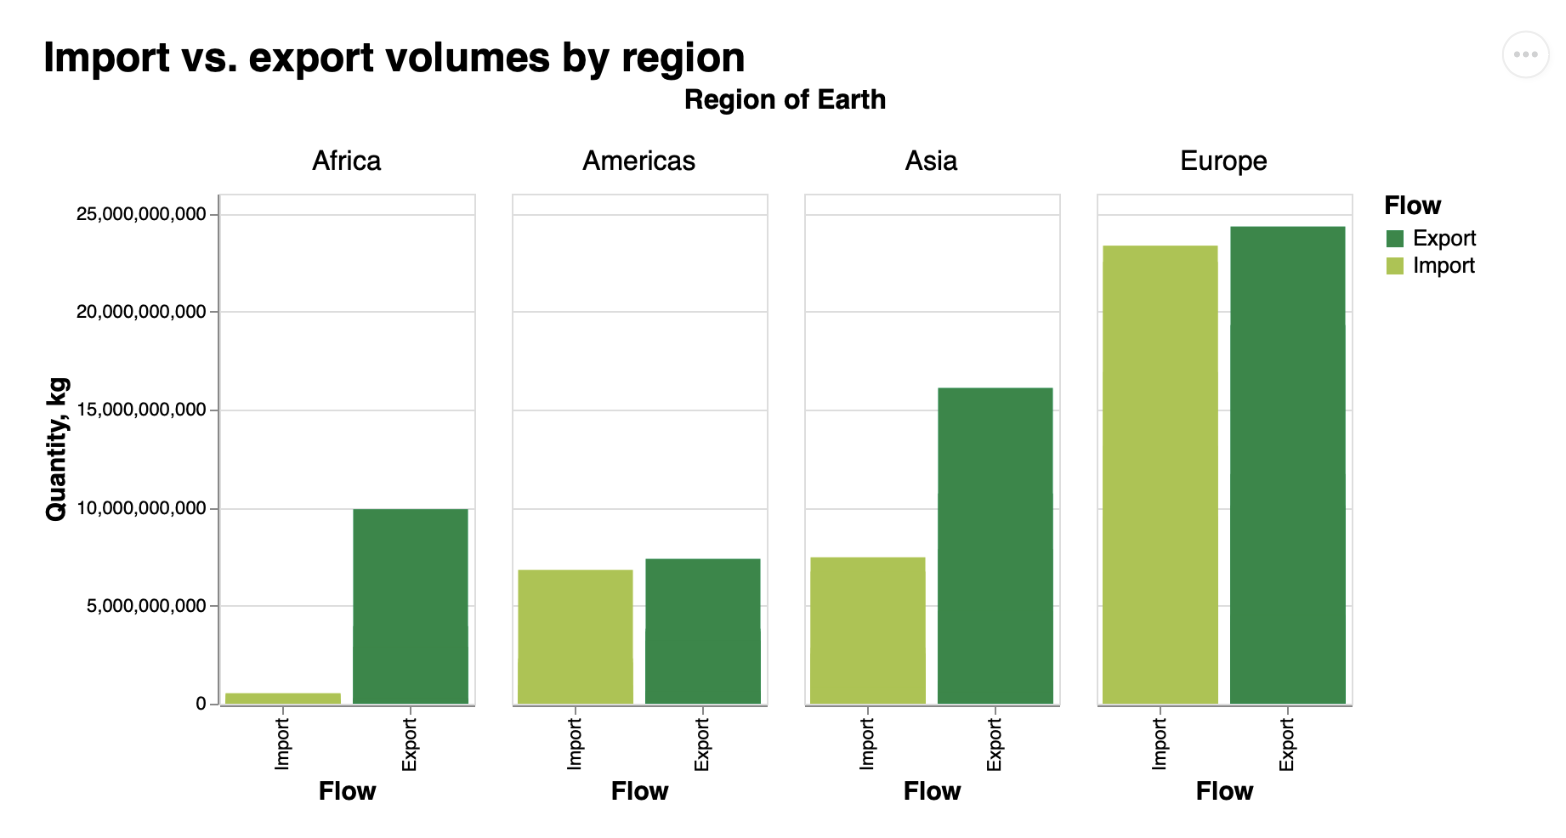

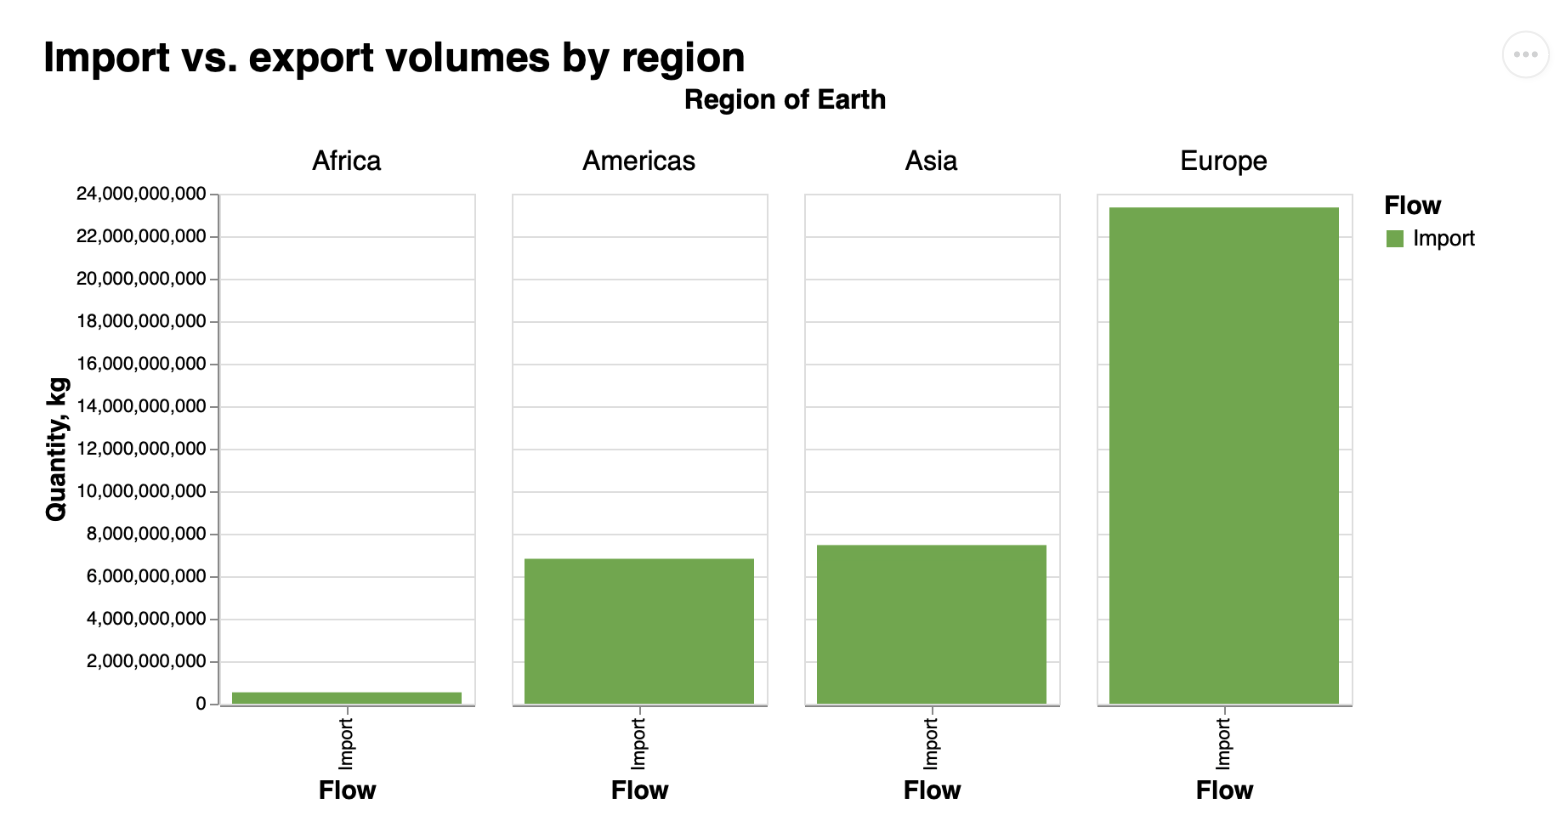

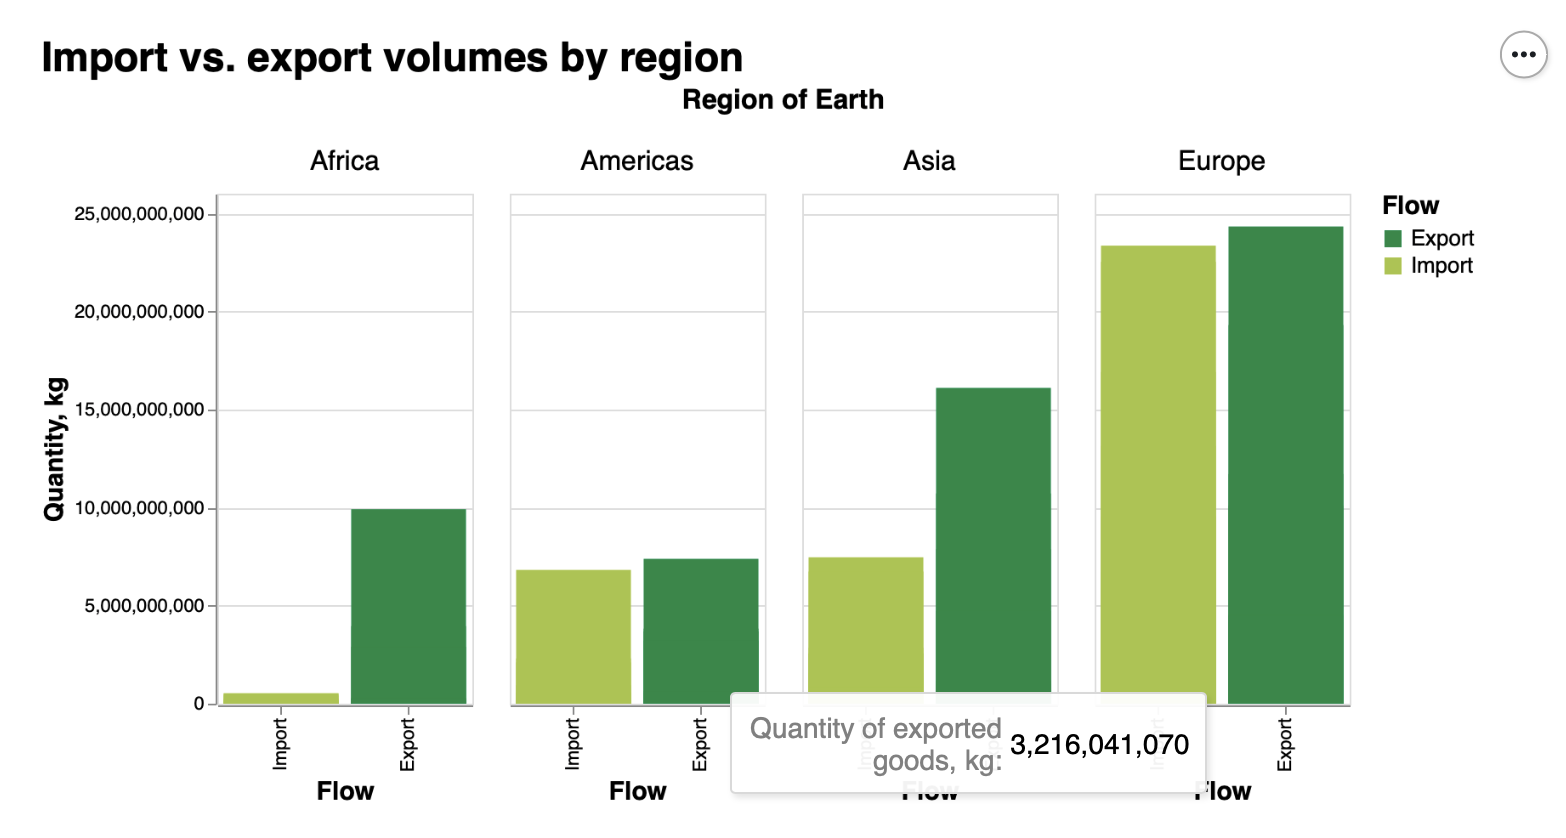